# rest of thing

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import glob
import sys
import pandasql as pdsql

sys.path.append("..")
import analysislib as alib

# ABOVE ZNONEOFTHE
sq = lambda q: pdsql.sqldf(q, globals())
sqflat = lambda q: alib.flatten(pdsql.sqldf(q, globals()).values.tolist())

plt.rcParams.update({'font.size': 14, 'legend.fontsize': 12})

In [3]:
compressionAlg = pd.read_csv("../../data/2025-03-27-time-14-19-14-fourth-run-compression-alg/master.csv", index_col=0)
compressionRatio = pd.read_csv("../../data/2025-03-28-time-12-00-50-fourth-run-compression-ratio/master.csv", index_col=0)

In [4]:
dumpsizes = pd.read_csv("../../dumpsizes", sep="\s+", header=None, names=["size", "filename"])
dumpsizes["dumpname"] = dumpsizes["filename"].apply(lambda s: s.split("/")[1].split(".")[0].split("-")[0])
dumpsizes["dumpID"] = dumpsizes["filename"].apply(lambda s: s.split("/")[1].split(".")[0])

dumpsizes["size_bytes"] = dumpsizes["size"].apply(alib.unformat_size_1)

dumpsizesGB = sq("SELECT dumpname, AVG(size_bytes)/(1024*1024*1024) as size_GB FROM dumpsizes GROUP BY dumpname ORDER BY size_GB DESC")


# Compression ratio (on heap dumps)

In [5]:
sq("""SELECT benchmark, MIN(data_bytes)/(1024*1024*1024.0) AS minGB, MAX(data_bytes)/(1024*1024*1024.0) AS maxGB
      FROM compressionRatio
      WHERE compression_alg='lzo'
      GROUP BY benchmark
      ORDER BY mAXGB""")

,benchmark,minGB,maxGB
0,jme,0.000000,0.012598
1,avrora,0.000000,0.024023
2,luindex,0.005078,0.026270
3,xalan,0.049023,0.049707
4,tomcat,0.052051,0.052051
5,eclipse,0.000000,0.074414
6,lusearch,0.075684,0.077051
7,jython,0.041797,0.078125
8,sunflow,0.190430,0.190430
9,kafka,0.296680,0.299316


In [6]:
compressionRatio.columns

Index(['benchmark', 'dumpNo', 'compression_alg', 'data_bytes',
       'compressed_bytes', 'total_bytes', 'compr_ratio'],
      dtype='object')

In [7]:
sq("""
    SELECT compression_alg, AVG(compr_ratio) 
    FROM compressionRatio 
    WHERE compr_ratio > 0
    GROUP BY compression_alg
""")

,compression_alg,AVG(compr_ratio)
0,lz4,2.741956
1,lzo,3.398771
2,zstd,4.678152


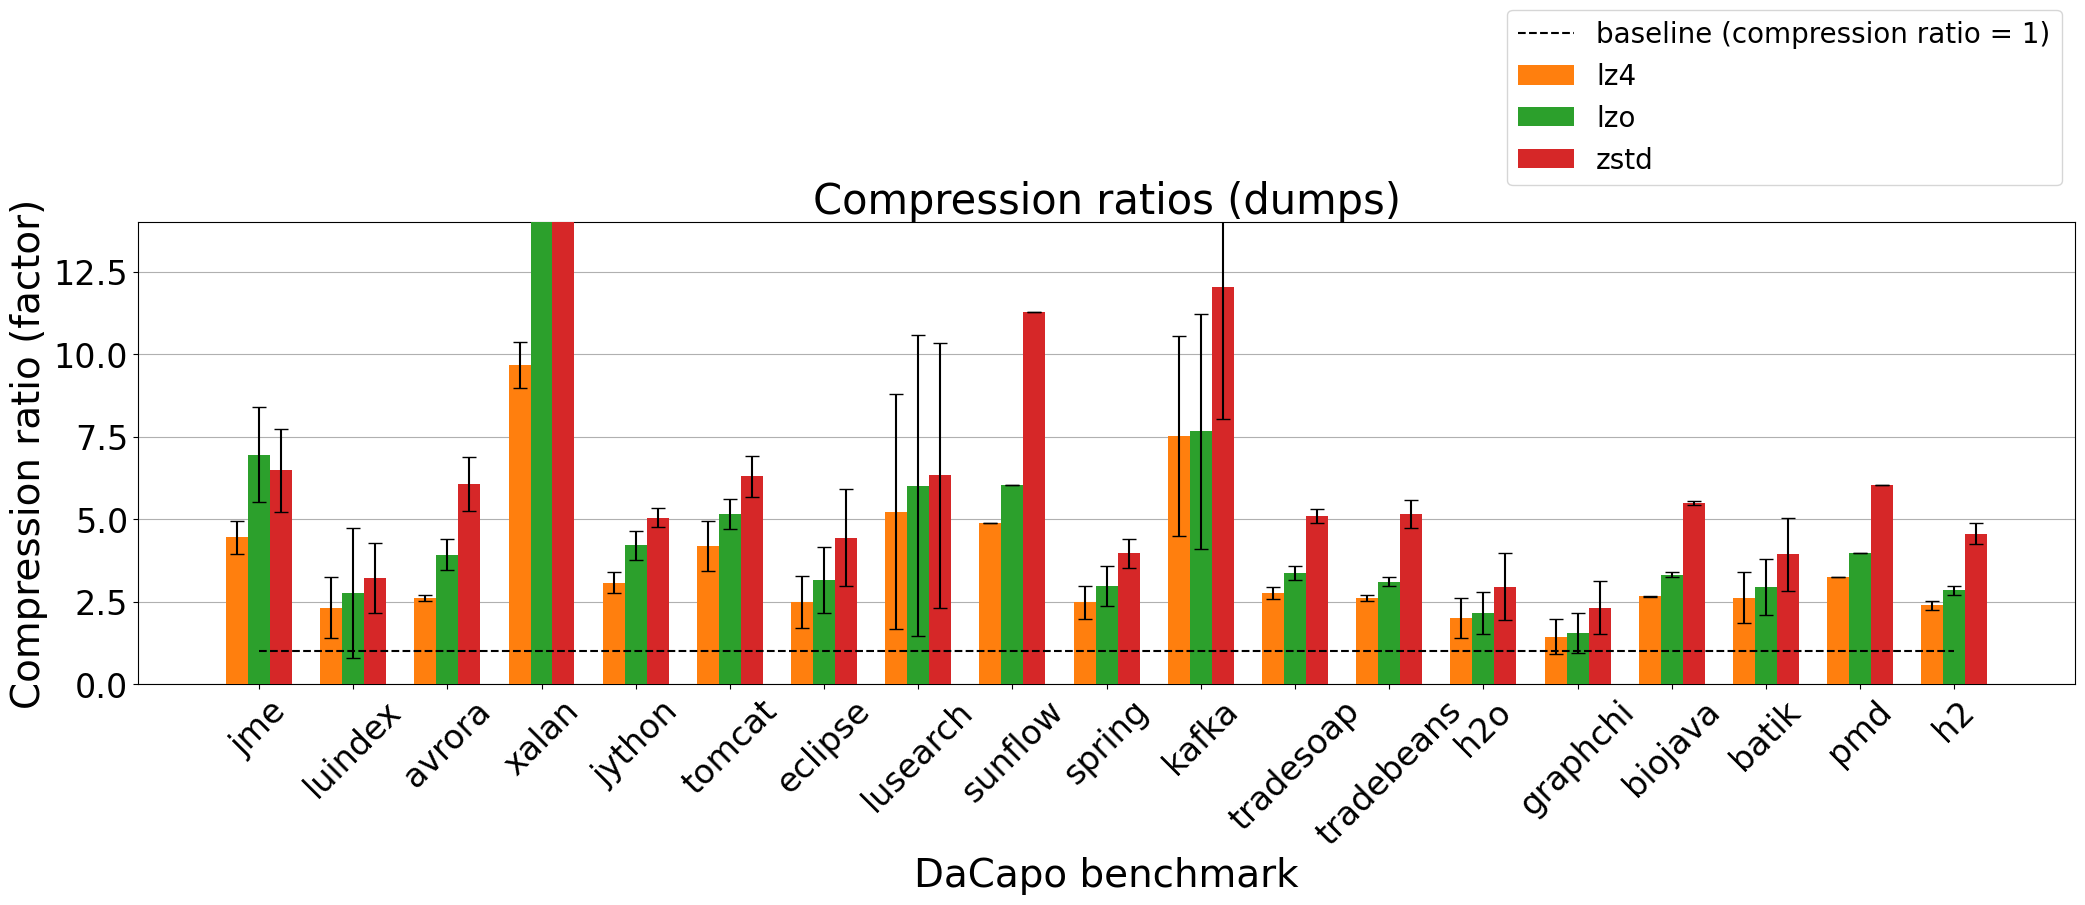

In [13]:
# Calculate means and standard deviations for compression ratios
compression_stats = sq("""SELECT benchmark, compression_alg, 
                                AVG(compr_ratio) as mean_ratio,
                                CASE 
                                    WHEN COUNT(compr_ratio) > 1 THEN 
                                        SQRT(SUM((compr_ratio - (SELECT AVG(compr_ratio) FROM compressionRatio cr2 WHERE cr2.benchmark = cr.benchmark AND cr2.compression_alg = cr.compression_alg)) * (compr_ratio - (SELECT AVG(compr_ratio) FROM compressionRatio cr2 WHERE cr2.benchmark = cr.benchmark AND cr2.compression_alg = cr.compression_alg))) / (COUNT(compr_ratio) - 1))
                                    ELSE 0 
                                END as std_ratio
                          FROM compressionRatio AS cr 
                          INNER JOIN dumpsizesGB AS ds ON cr.benchmark = ds.dumpname 
                          WHERE compr_ratio > 0 
                          GROUP BY benchmark, compression_alg 
                          ORDER BY compression_alg, ds.size_GB""")

# Extract means and standard deviations
means = sqflat("SELECT mean_ratio FROM compression_stats")
stds = sqflat("SELECT std_ratio FROM compression_stats")

alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT dumpname FROM dumpsizesGB ORDER BY size_GB"),
    means,
    labels=sqflat("SELECT DISTINCT compression_alg FROM compressionRatio ORDER BY compression_alg"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Compression ratio (factor)",
    title="",
    colors=["#ff7f0e", "#2ca02c", "#d62728"],
    yerr=stds,  # Add error bars
    show=False
)

nb = len(sqflat("SELECT DISTINCT benchmark FROM compressionRatio"))
plt.plot(range(nb), np.ones(nb), linestyle='--', zorder=100, color="#000000", label="baseline (compression ratio = 1)") # draw a line at 1 for baseline purposes

plt.ylim([0, 14])

plt.gca().get_yaxis().label.set_fontsize(28)
plt.gca().get_xaxis().label.set_fontsize(28)
plt.gca().tick_params(axis='x', labelsize=24)
plt.gca().tick_params(axis='y', labelsize=24)
plt.xticks(rotation=45)

plt.legend(fontsize=20, bbox_to_anchor=(1, 1.05), loc="lower right")

plt.savefig("../../processed-data/2025-03-28-heapdump/compratios.png", bbox_inches="tight")
plt.title("Compression ratios (dumps)")
plt.gca().title.set_fontsize(30)
plt.savefig("../../processed-data/2025-03-28-heapdump/compratios-w-title.png", bbox_inches="tight")
plt.show()

In [20]:
sq("SELECT compression_alg, benchmark, mean_ratio FROM compression_stats WHERE benchmark='xalan'")

,compression_alg,benchmark,mean_ratio
0,lz4,xalan,9.670511
1,lzo,xalan,16.308343
2,zstd,xalan,24.400702


In [57]:
# get the compression ratios for zstd
sq("SELECT benchmark, AVG(data_bytes / total_bytes) AS r FROM compressionRatio WHERE compression_alg='zstd' GROUP BY benchmark ORDER BY r DESC")

,benchmark,r
0,xalan,24.400702
1,kafka,12.056629
2,sunflow,11.271676
3,lusearch,6.330893
4,tomcat,6.301989
5,pmd,6.030679
6,jme,5.900176
7,biojava,5.494492
8,avrora,5.463017
9,tradebeans,5.161158


# Compression algorithms (on heap dumps)

In [108]:
dumps = pd.read_csv("../../data/2025-04-17-time-13-32-01-fourth-run-dumps/master.csv", index_col=0)

In [68]:
dumps.columns

Index(['cbSize', 'cioengine', 'ciodepth', 'crw', 'cnproc', 'cdevice',
       'cdirect', 'cmemlim', 'cdumpbc', 'cdumpno', 'cfile', 'readBW_bytes',
       'readBW', 'writeBW_bytes', 'writeBW', 'avgreadlat_ns', 'avgreadlat',
       'avgwritelat_ns', 'avgwritelat', 'USR_UTIL_perc', 'SYS_UTIL_perc',
       'IOW_UTIL_perc', 'IDL_UTIL_perc', 'CPU_UTIL_perc',
       'diskutil-TOTAL_READS(KB)', 'diskutil-TOTAL_WRITES(KB)',
       'diskutil-TOTAL_READS(MB)', 'diskutil-TOTAL_WRITES(MB)',
       'diskutil-TOTAL_READS(GB)', 'diskutil-TOTAL_WRITES(GB)',
       'diskutil-rMB/s', 'diskutil-wMB/s', 'diskutil-AVGRQ-SZ',
       'diskutil-AVGQU-SZ', 'diskutil-DEV_UTIL'],
      dtype='object')

In [69]:
# sq("SELECT cdevice, cdumpbc, AVG(readBW_bytes) FROM dumps WHERE crw='read' GROUP BY cdevice, cdumpbc")
sq("SELECT cdevice, cdumpbc, readBW_bytes FROM dumps WHERE crw='read' AND cdumpbc='h2'")

,cdevice,cdumpbc,readBW_bytes
0,zram-lz4,h2,1994100973
1,zram-lz4,h2,1802868276
2,zram-lz4,h2,1888193525
3,zram-lz4,h2,1738443377
4,zram-lz4,h2,1703698604
5,zram-zstd,h2,1652627473
6,zram-zstd,h2,1479318391
7,zram-zstd,h2,1389325467
8,zram-zstd,h2,1353622901
9,zram-zstd,h2,1313075682


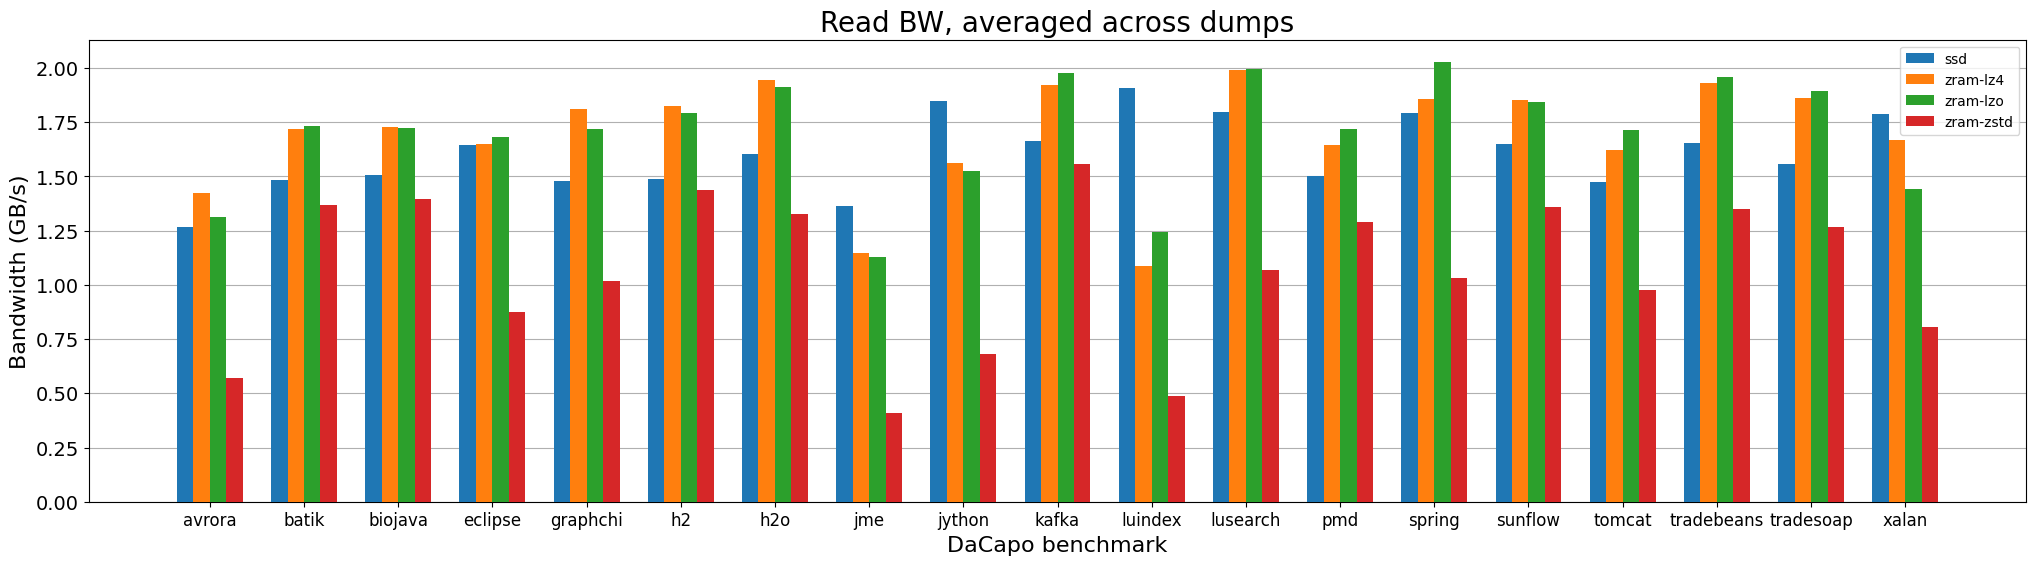

In [70]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cdumpbc FROM dumps ORDER BY cdumpbc"),
    np.array(sqflat("SELECT AVG(readBW_bytes) FROM dumps WHERE crw='read' GROUP BY cdevice, cdumpbc"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Bandwidth (GB/s)",
    title="Read BW, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.show()

In [71]:
sq("""
    SELECT cdumpbc, cdevice, AVG(d.readBW_bytes) 
    FROM dumps AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname
    WHERE d.crw='read' AND d.cdevice !='zram-zstd'
    GROUP BY cdumpbc, cdevice
    ORDER BY ds.size_GB DESC
""")
print("suppress output")

suppress output


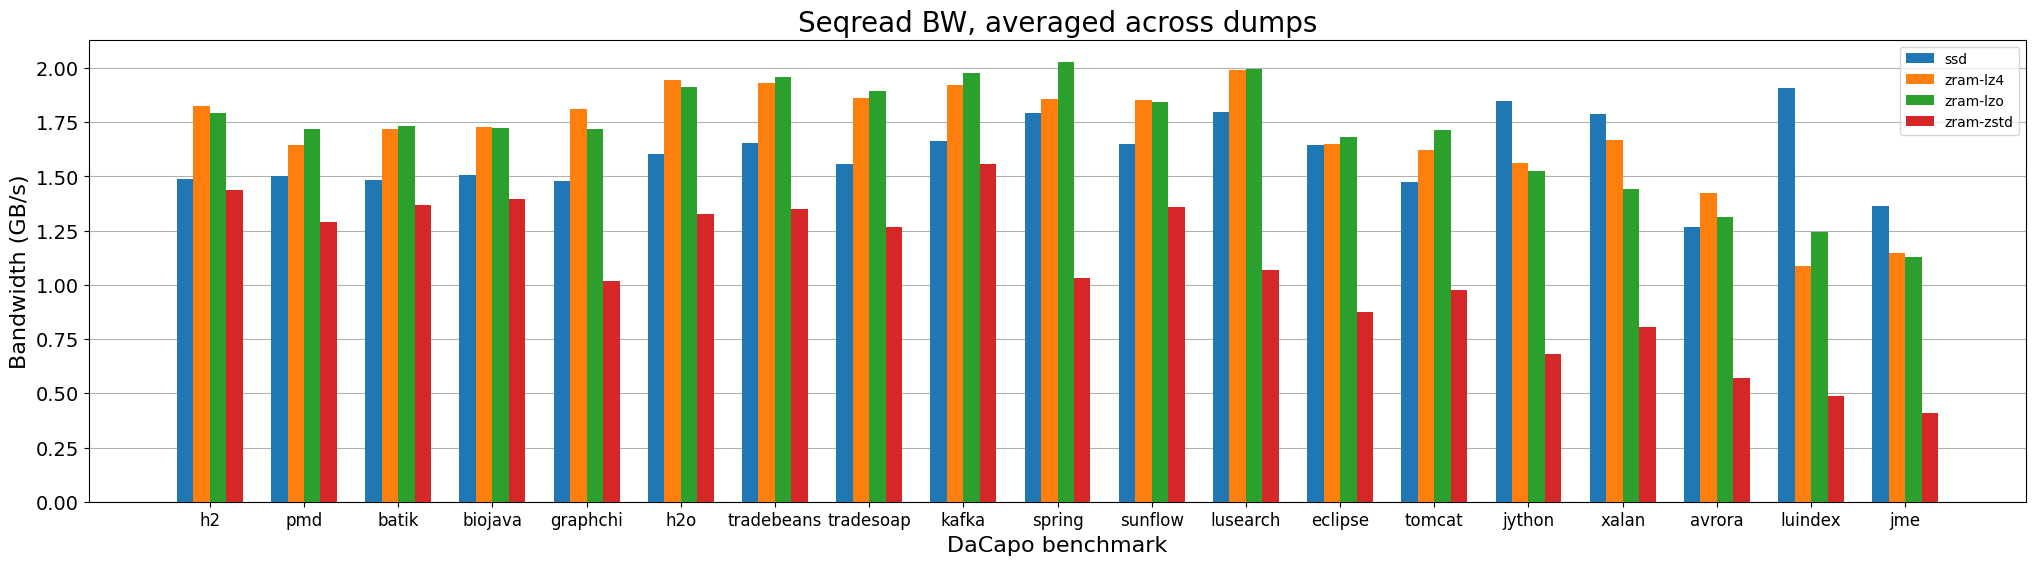

In [73]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    np.array(sqflat("SELECT AVG(d.readBW_bytes) FROM dumps AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Bandwidth (GB/s)",
    title="Seqread BW, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-seqread.png")
plt.show()

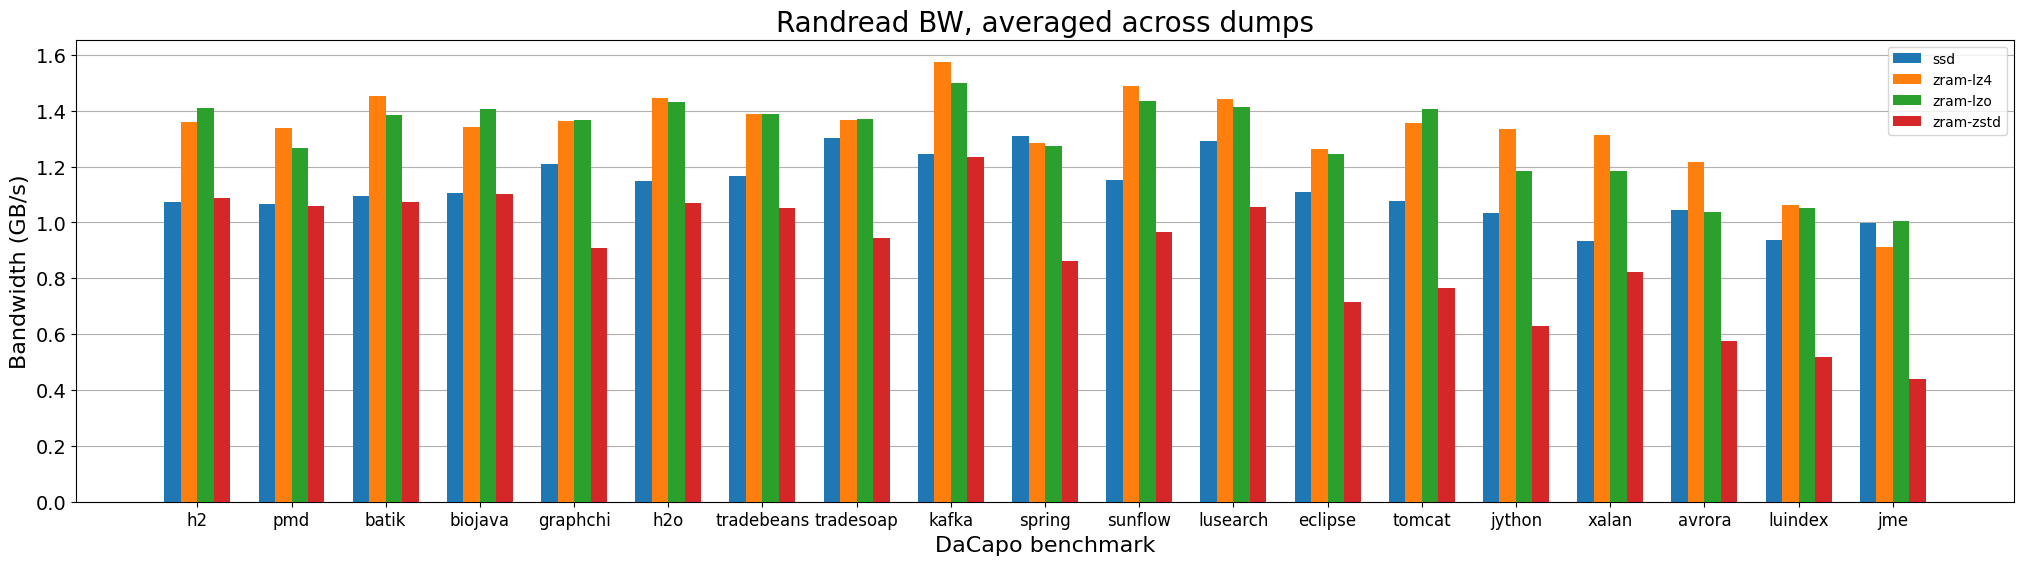

In [109]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    np.array(sqflat("SELECT AVG(d.readBW_bytes) FROM dumps AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='randread' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Bandwidth (GB/s)",
    title="Randread BW, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-randread.png")
plt.show()

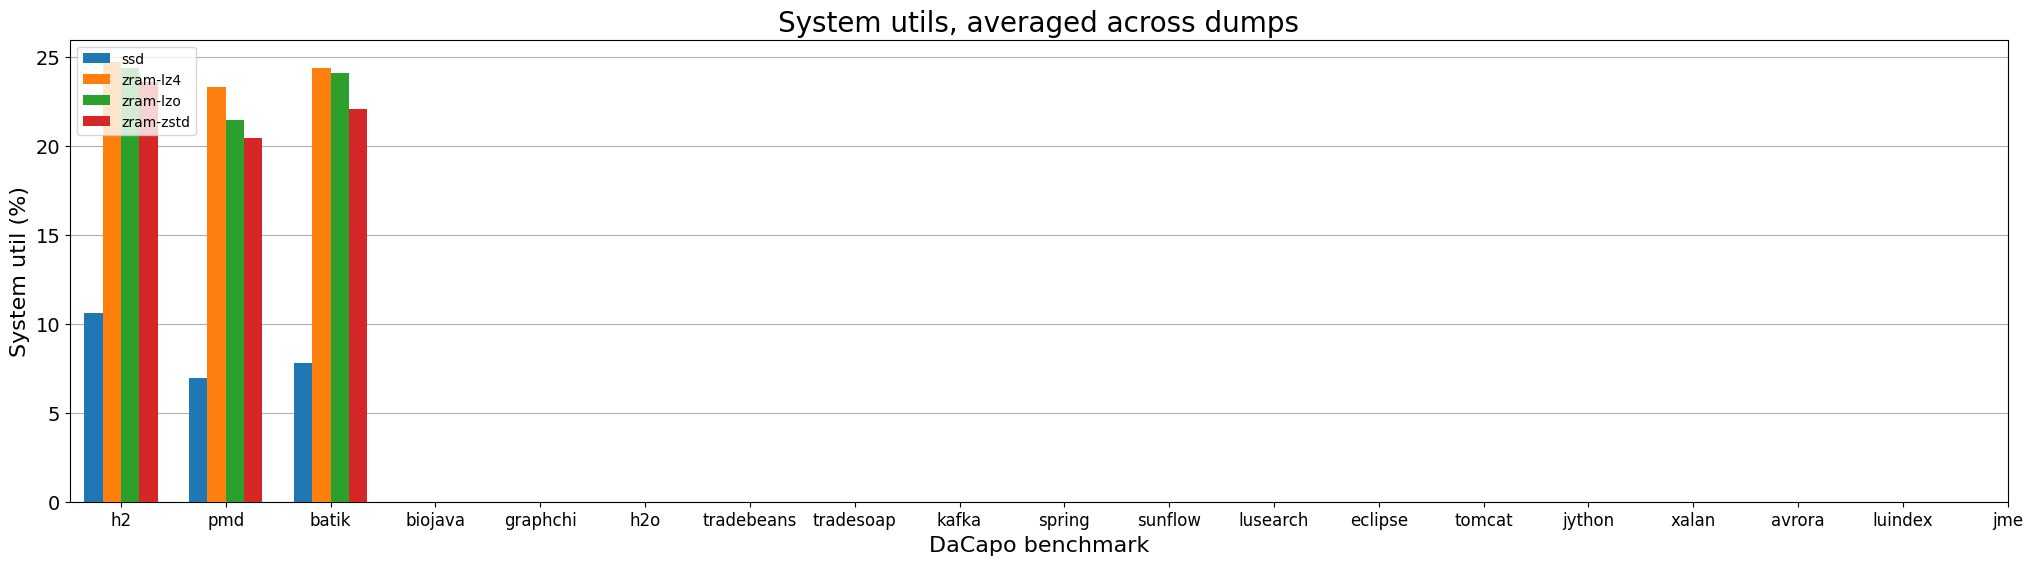

In [82]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.SYS_UTIL_perc) FROM dumps AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="System util (%)",
    title="System utils, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-sysutil.png")

plt.show()

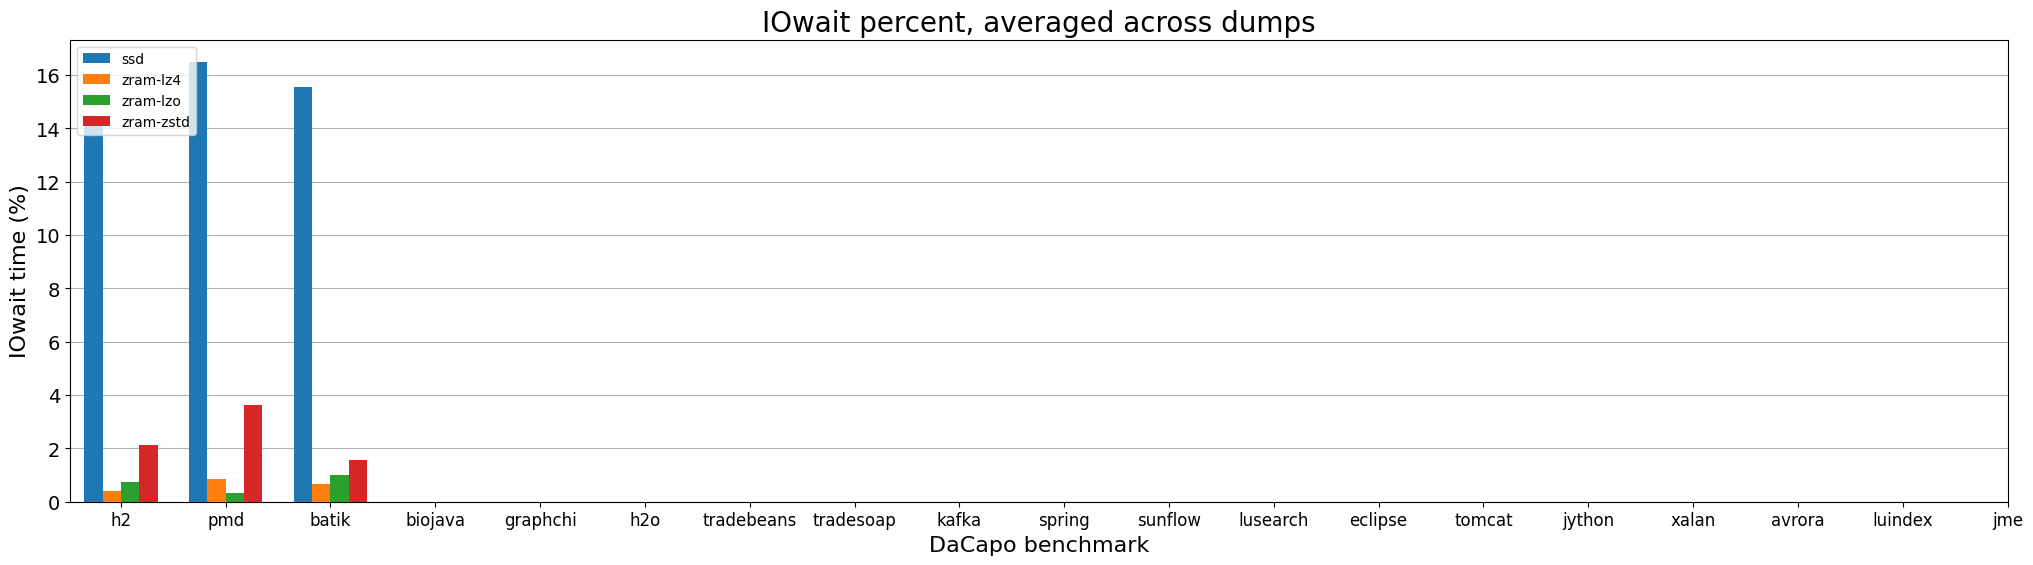

In [88]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.IOW_UTIL_perc) FROM dumps AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="IOwait time (%)",
    title="IOwait percent, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-iowait.png")

plt.show()

In [84]:
sq("SELECT cdevice, cdumpbc, AVG(d.SYS_UTIL_perc) FROM dumps AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' AND cdumpbc='h2' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC")

,cdevice,cdumpbc,AVG(d.SYS_UTIL_perc)
0,ssd,h2,10.61806
1,zram-lz4,h2,24.74268
2,zram-lzo,h2,24.39742
3,zram-zstd,h2,23.61048


i have a feeling we are observing this because i put the number of processes down to 8 whoops lol
- I'll try 32 again and check to make sure

# Compression algorithm but on extended dumps

In [106]:
dumps2 = pd.read_csv("../../data/2025-04-25-time-01-10-01-fourth-run-dumps-extendedfile/master.csv", index_col=0)

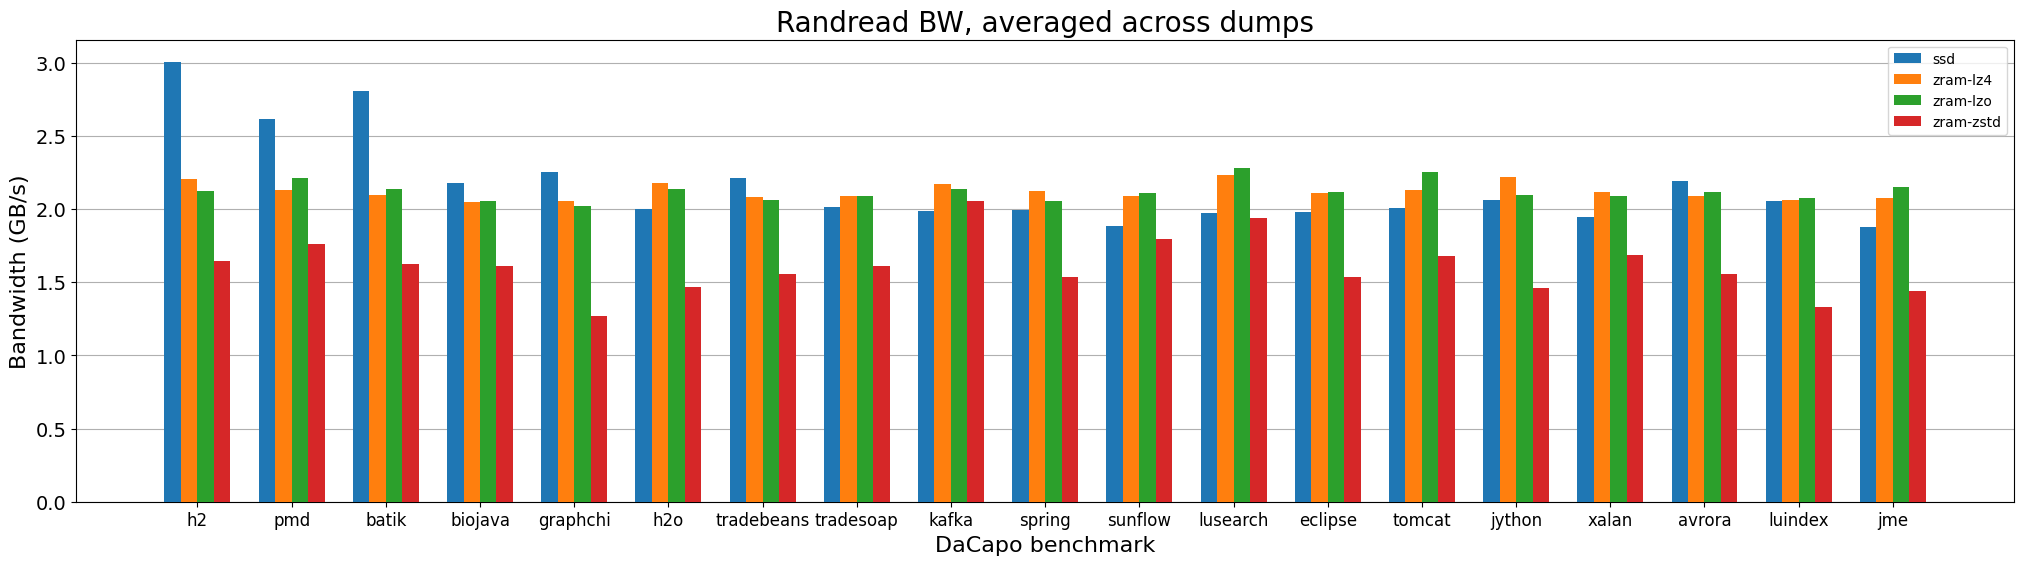

In [107]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    np.array(sqflat("SELECT AVG(d.readBW_bytes) FROM dumps2 AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps2 ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Bandwidth (GB/s)",
    title="Randread BW, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-read-extendedfiles.png")
plt.show()

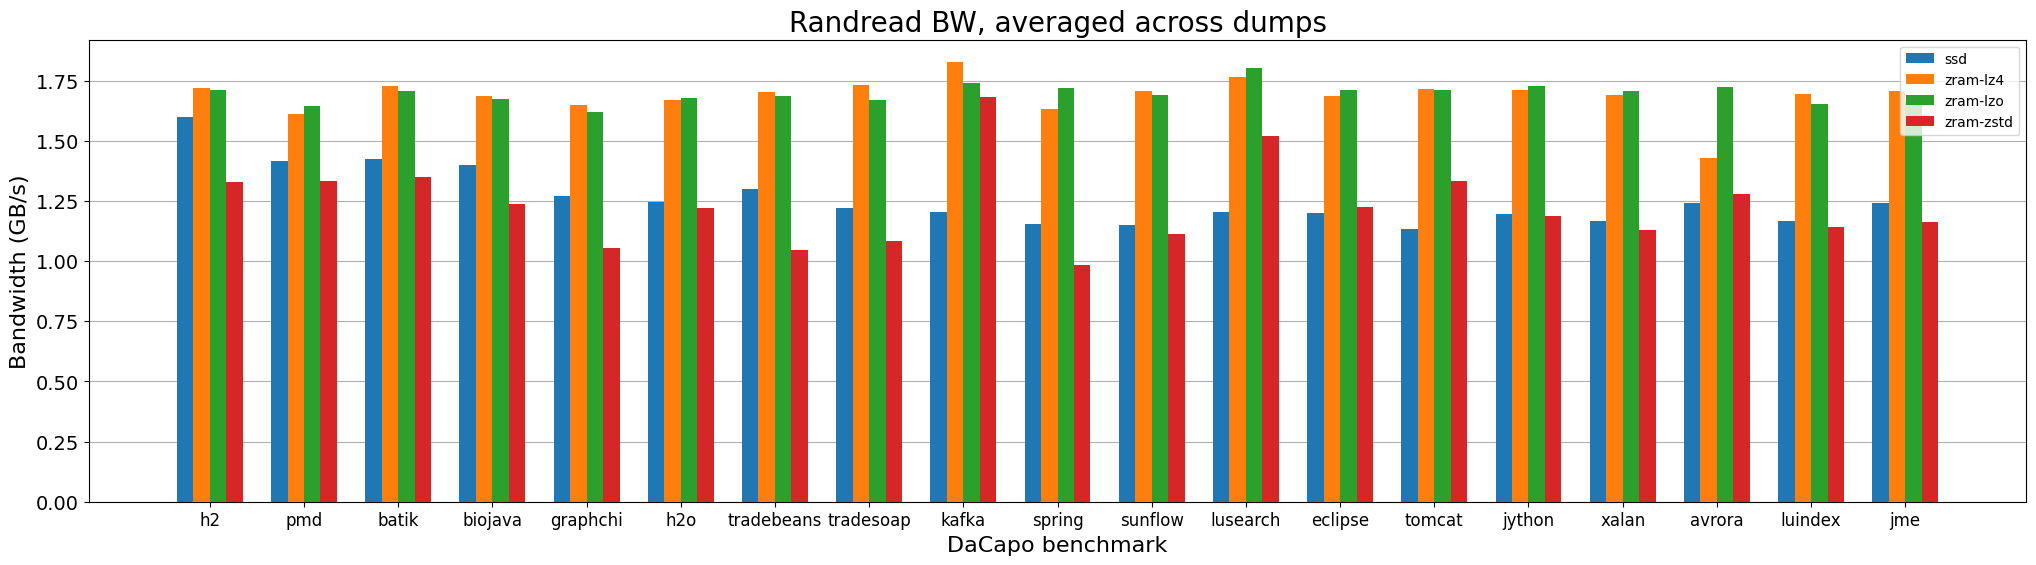

In [76]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    np.array(sqflat("SELECT AVG(d.readBW_bytes) FROM dumps2 AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='randread' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps2 ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Bandwidth (GB/s)",
    title="Randread BW, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-randread-extendedfiles.png")
plt.show()

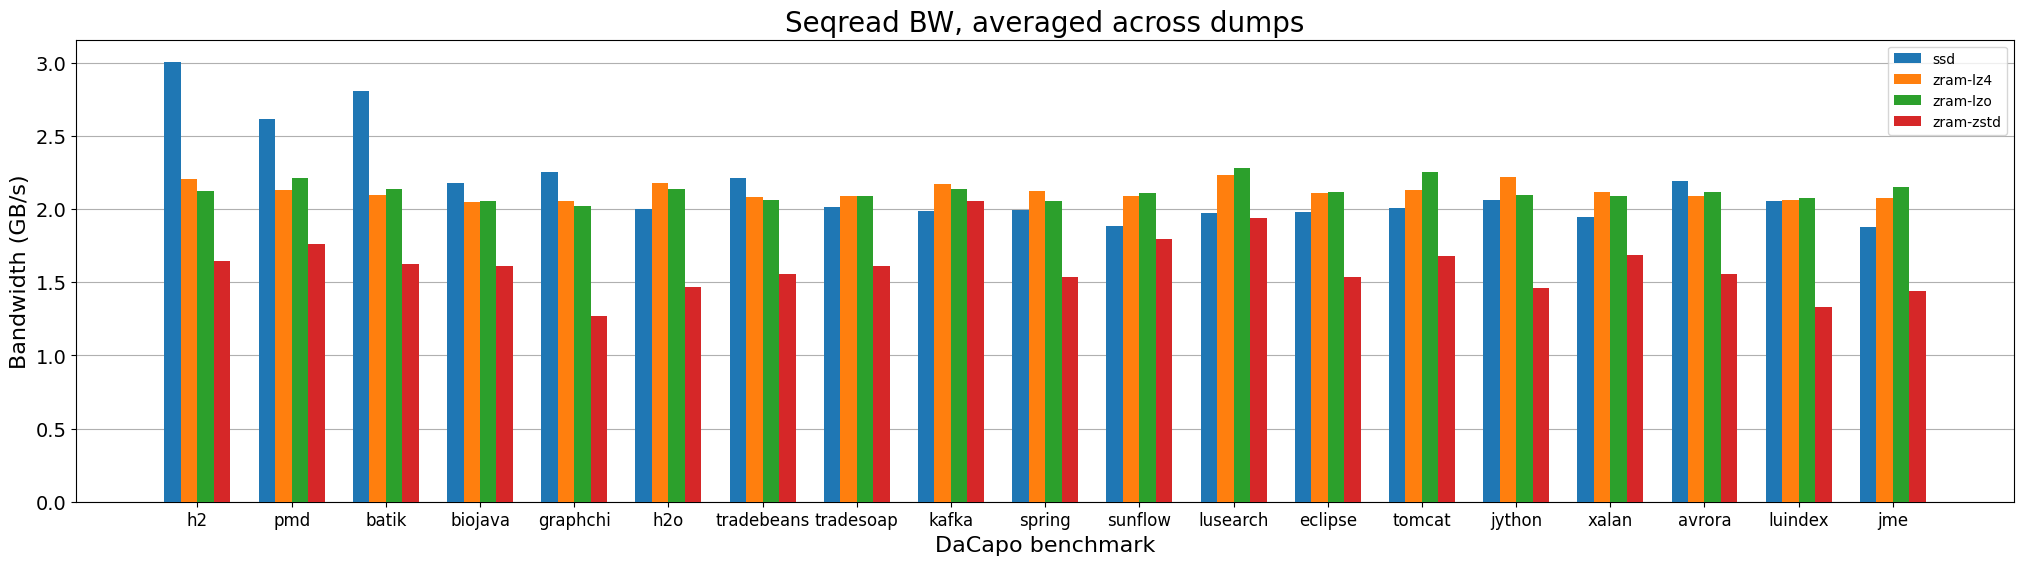

In [78]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    np.array(sqflat("SELECT AVG(d.readBW_bytes) FROM dumps2 AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps2 ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Bandwidth (GB/s)",
    title="Seqread BW, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-seqread-extendedfiles.png")
plt.show()

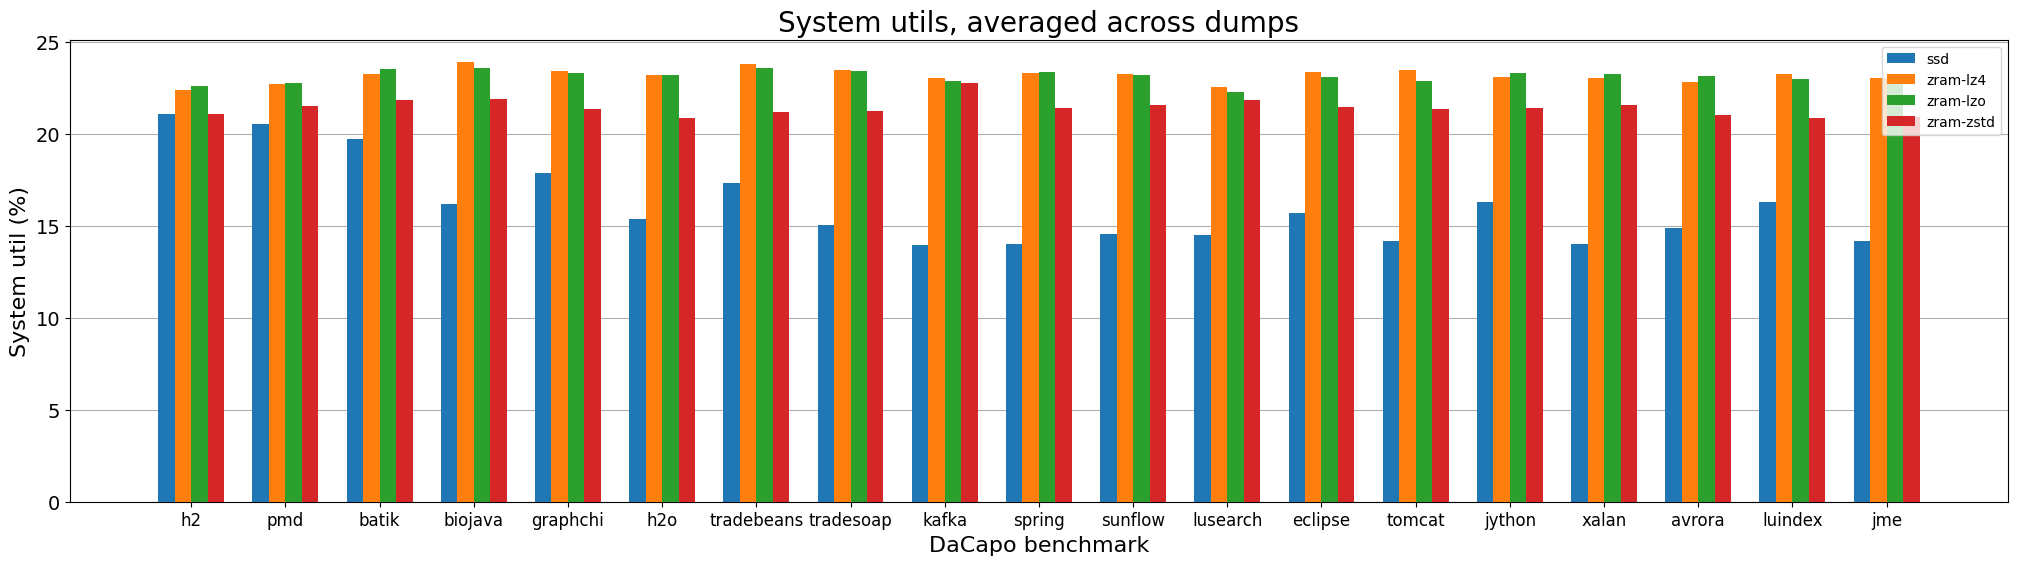

In [81]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.SYS_UTIL_perc) FROM dumps2 AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="System util (%)",
    title="System utils, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-sysutil-extendedfile.png")

plt.show()

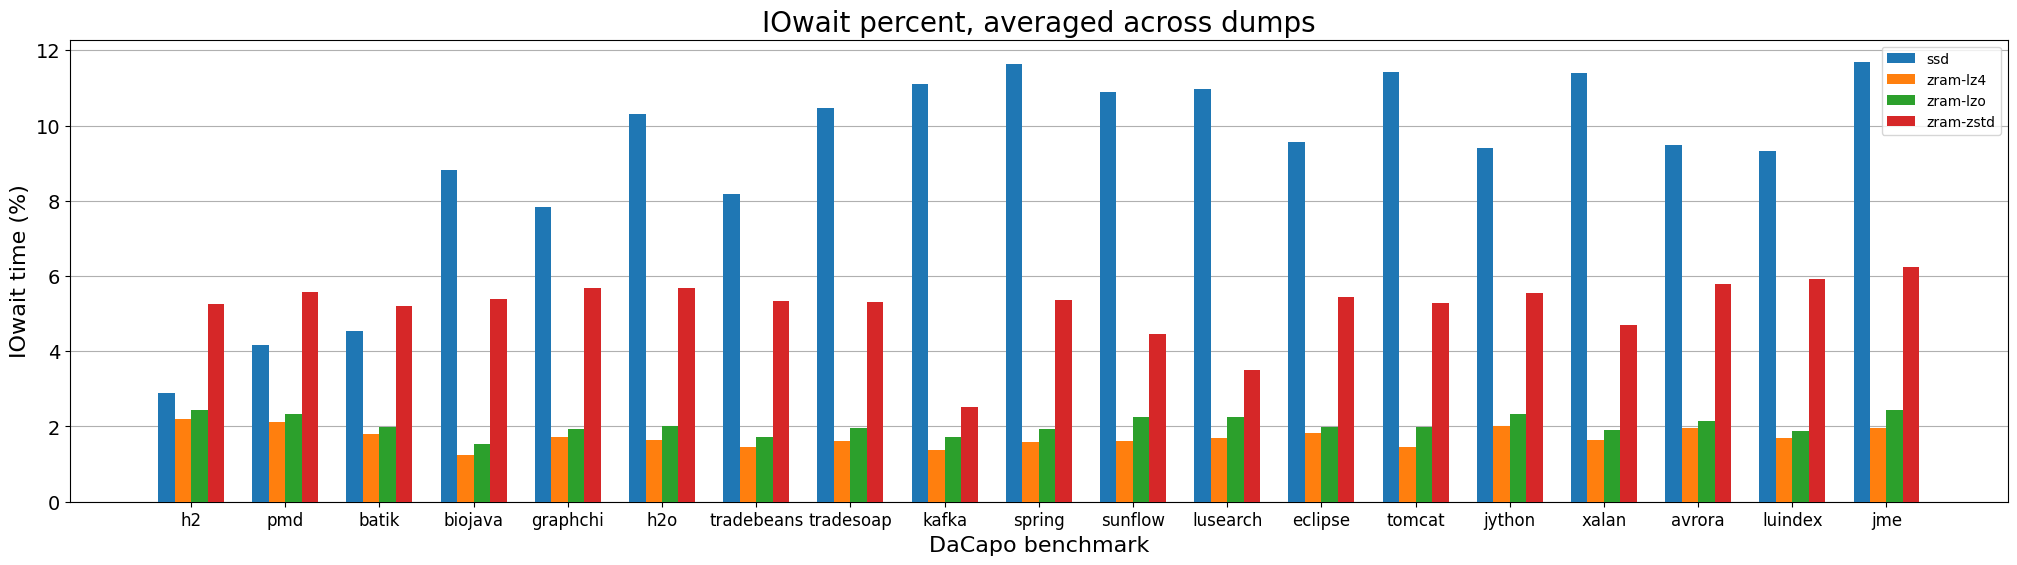

In [86]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.IOW_UTIL_perc) FROM dumps2 AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="IOwait time (%)",
    title="IOwait percent, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-iowait-extendedfile.png")

plt.show()

In [85]:
sq("SELECT cdevice, cdumpbc, AVG(d.SYS_UTIL_perc) FROM dumps2 AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' AND cdumpbc='h2' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC")

,cdevice,cdumpbc,AVG(d.SYS_UTIL_perc)
0,ssd,h2,21.06896
1,zram-lz4,h2,22.37248
2,zram-lzo,h2,22.56642
3,zram-zstd,h2,21.06650


# Latency analysis (heap dump experiments)

In [11]:
df_hd = pd.read_csv("../../data/2025-04-17-time-13-32-01-fourth-run-dumps/master.csv")
df_hd_ext = pd.read_csv("../../data/2025-04-30-time-15-29-46-fourth-run-dumps-sync/master.csv")

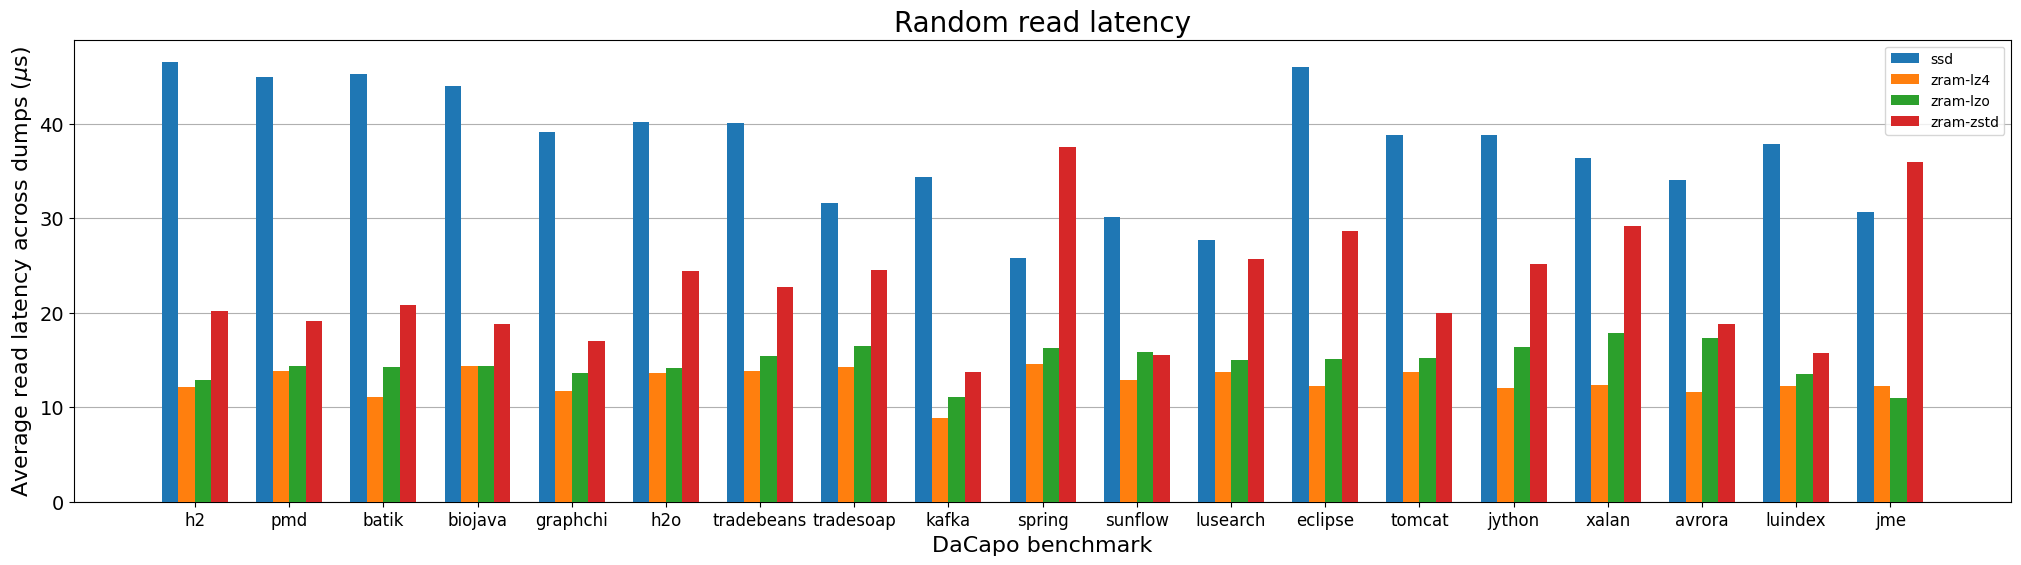

In [68]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.avgreadlat) FROM df_hd AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='randread' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Average read latency across dumps ($\mu$s)",
    title="Random read latency",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/randread-latency.png")

plt.show()

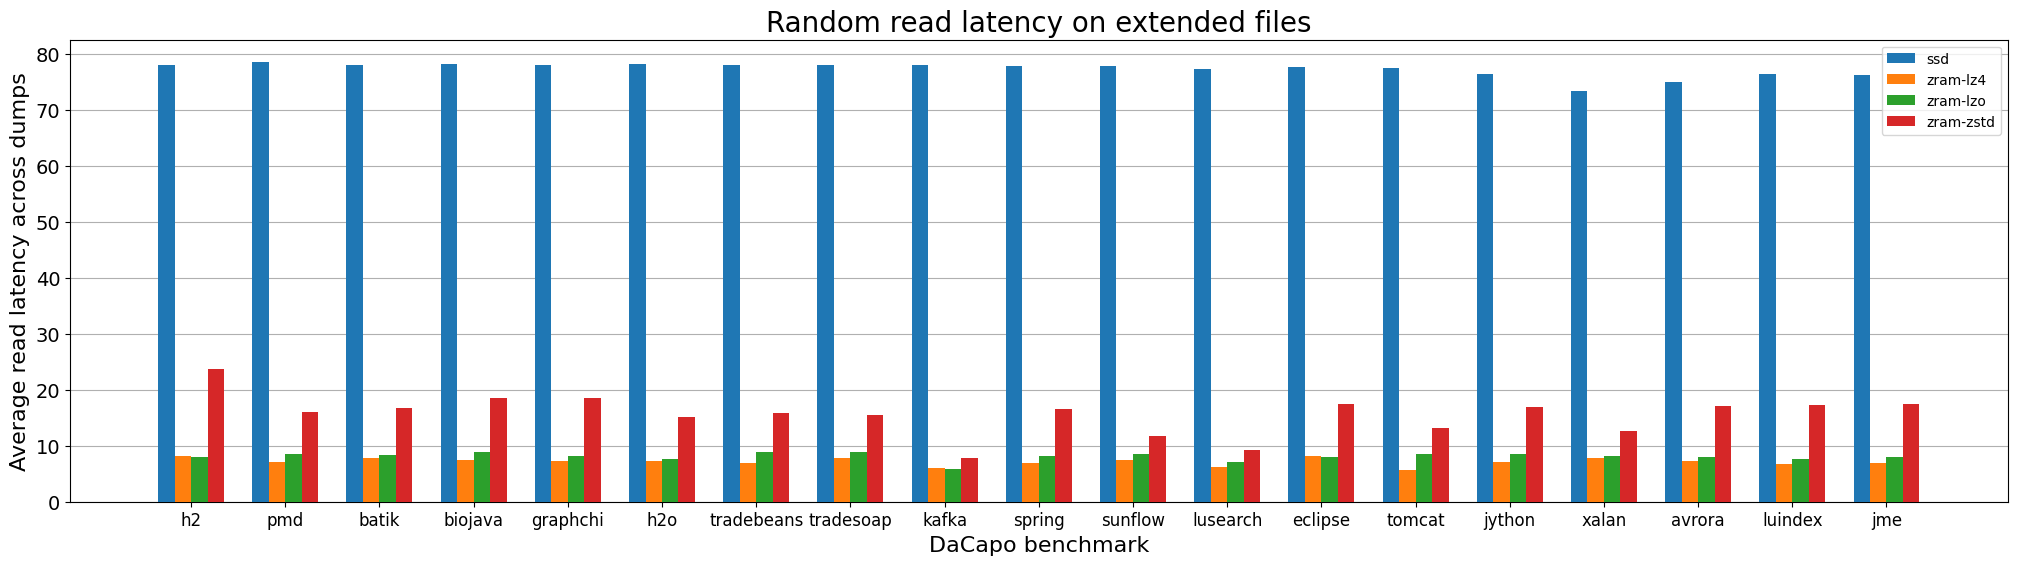

In [72]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.avgreadlat) FROM df_hd_ext AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='randread' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd_ext ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Average read latency across dumps",
    title="Random read latency on extended files",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/randread-latency-extendedfile.png")

plt.show()

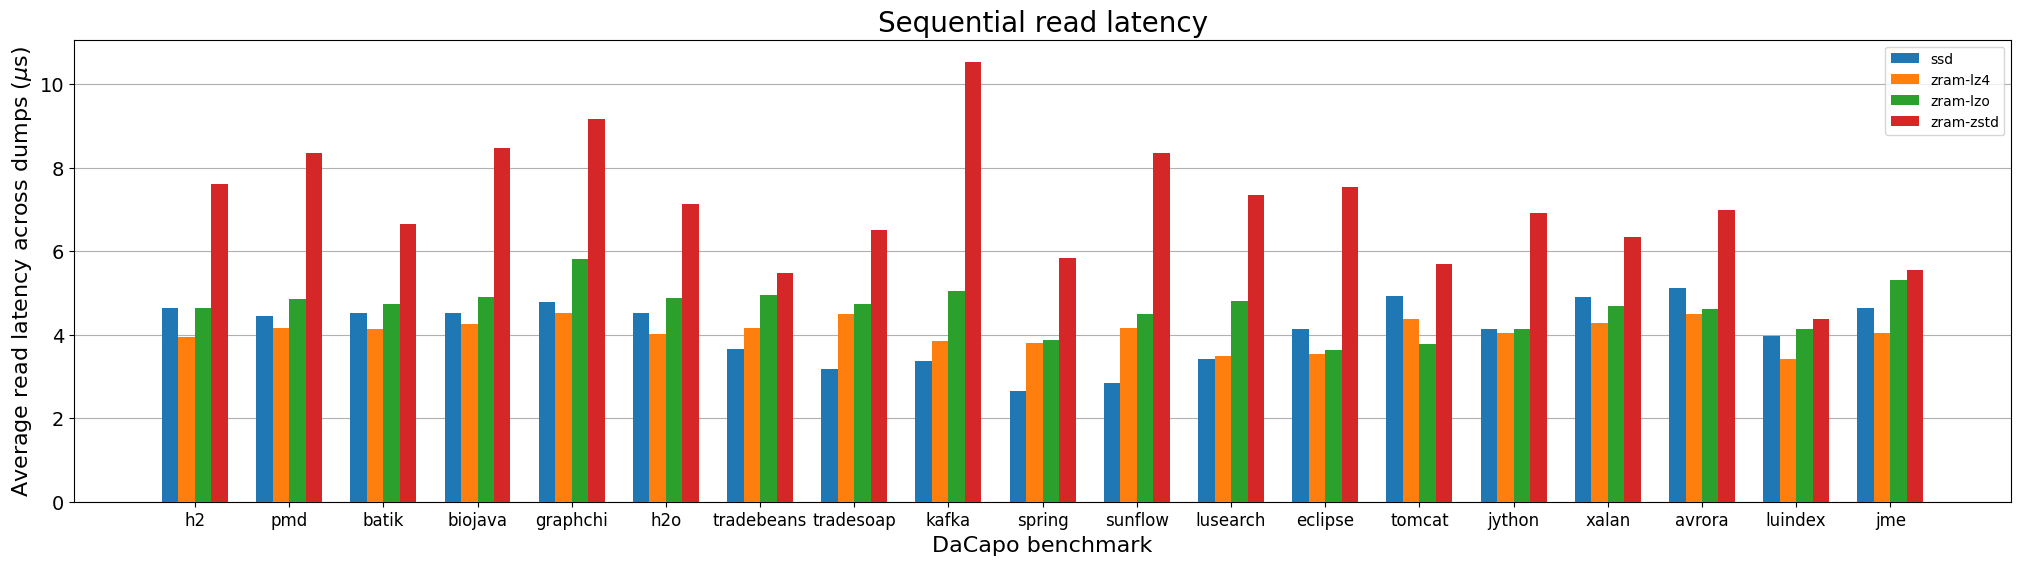

In [71]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.avgreadlat) FROM df_hd AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Average read latency across dumps ($\mu$s)",
    title="Sequential read latency",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/seqread-latency.png")

plt.show()

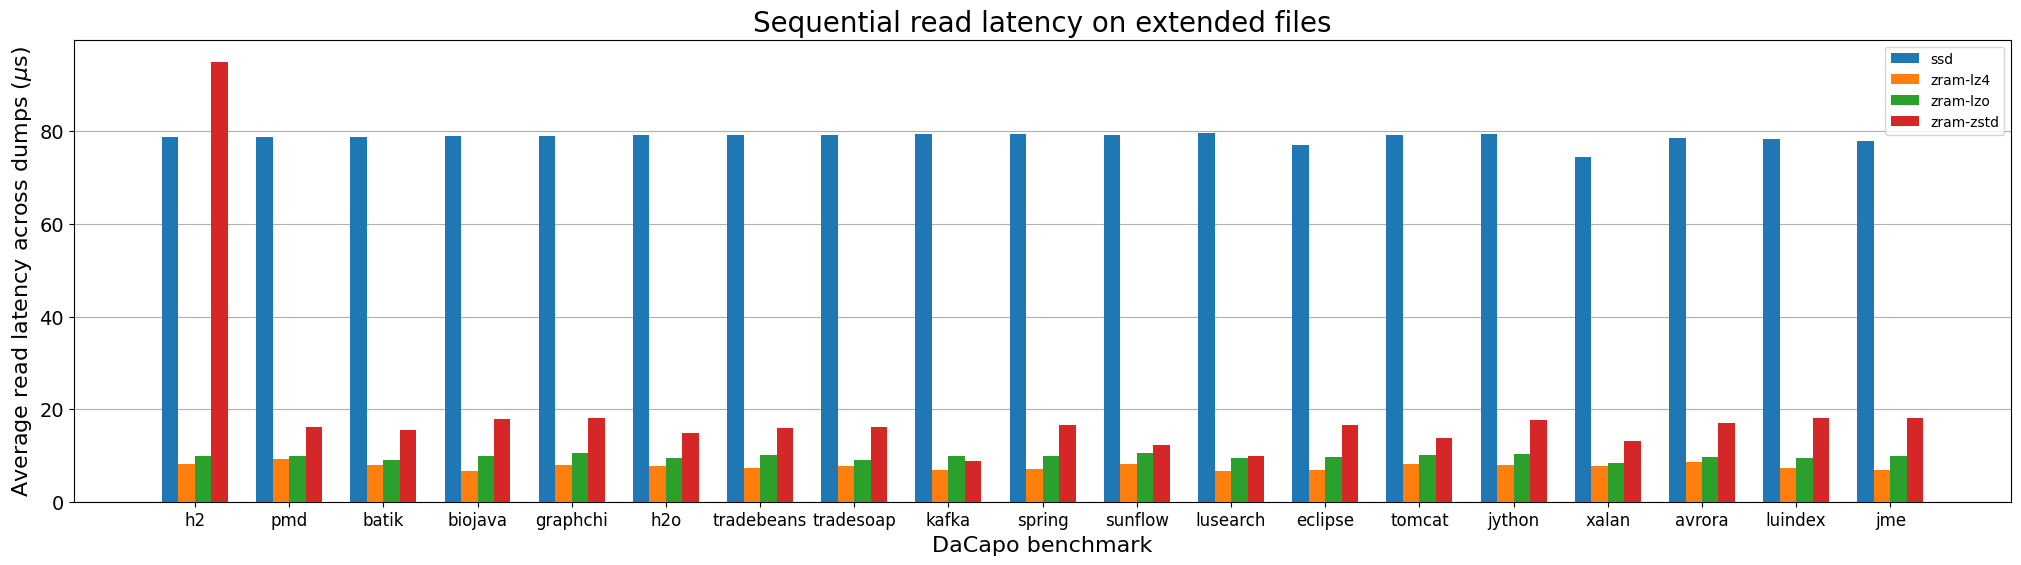

In [80]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.avgreadlat) FROM df_hd_ext AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Average read latency across dumps ($\mu$s)",
    title="Sequential read latency on extended files",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/seqread-latency-extendedfile.png")

plt.show()

In [85]:
sq("SELECT cdevice, cdumpbc, COUNT(*), AVG(d.readBW_bytes) FROM df_hd AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='randread' GROUP BY cdevice, cdumpbc ORDER BY ds.size_GB DESC, cdevice")

,cdevice,cdumpbc,COUNT(*),AVG(d.readBW_bytes)
0,ssd,h2,5,1.074628e+09
1,zram-lz4,h2,5,1.359733e+09
2,zram-lzo,h2,5,1.408022e+09
3,zram-zstd,h2,5,1.086910e+09
4,ssd,pmd,2,1.066932e+09
...,...,...,...,...
71,zram-zstd,luindex,5,5.177953e+08
72,ssd,jme,5,9.989884e+08
73,zram-lz4,jme,5,9.128536e+08
74,zram-lzo,jme,5,1.006359e+09


# (Debugging) using sync engine instead

In [17]:
df_hd_sync = pd.read_csv("../../data/2025-04-30-time-15-29-46-fourth-run-dumps-sync-timed/master.csv")

In [18]:
sq("SELECT cdevice, cdumpbc, cdumpno, avgreadlat_ns FROM df_hd_sync")

,cdevice,cdumpbc,cdumpno,avgreadlat_ns
0,zram-lz4,jme,9,5544.523708
1,zram-lz4,jme,3,5943.160202
2,zram-lz4,jme,1,5750.618361
3,zram-lz4,jme,7,8353.810971
4,zram-lz4,jme,5,8822.834112
...,...,...,...,...
683,zram-lzo,batik,11,10024.225680
684,zram-lzo,batik,8,7703.935081
685,zram-lzo,batik,2,6880.007249
686,zram-lzo,batik,5,9599.163764


In [93]:
sq("SELECT cdevice, cdumpbc, AVG(avgreadlat_ns) FROM df_hd_sync WHERE crw = 'read' GROUP BY cdevice, cdumpbc ORDER BY cdumpbc")

,cdevice,cdumpbc,AVG(avgreadlat_ns)
0,ssd,avrora,78453.646392
1,zram-lz4,avrora,8535.993275
2,zram-lzo,avrora,9634.909524
3,zram-zstd,avrora,16961.572606
4,ssd,batik,78767.183885
...,...,...,...
71,zram-zstd,tradesoap,16232.050371
72,ssd,xalan,74472.514503
73,zram-lz4,xalan,7718.204659
74,zram-lzo,xalan,8321.021051


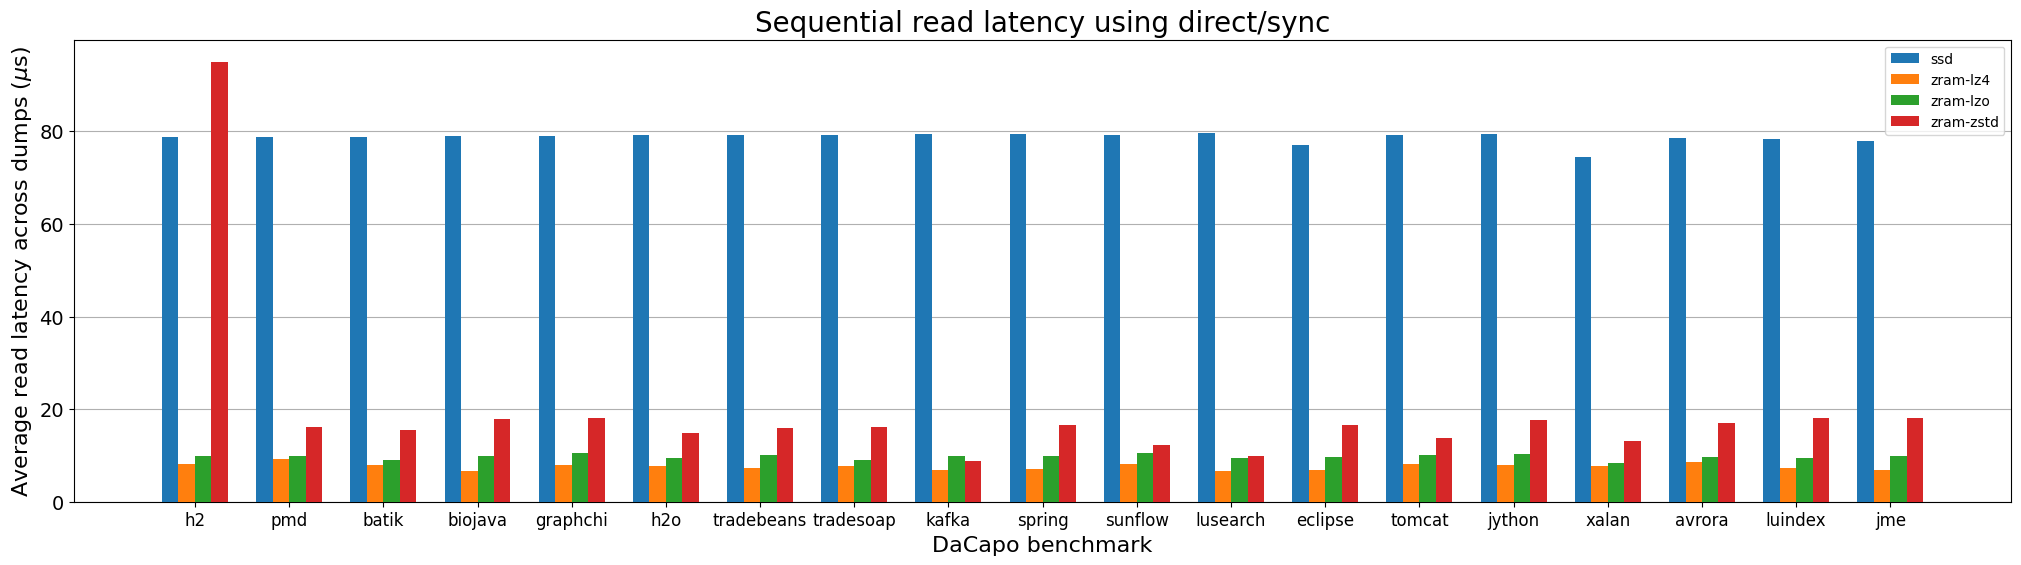

In [94]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.avgreadlat) FROM df_hd_sync AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Average read latency across dumps ($\mu$s)",
    title="Sequential read latency using direct/sync",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/seqread-latency-sync.png")

plt.show()

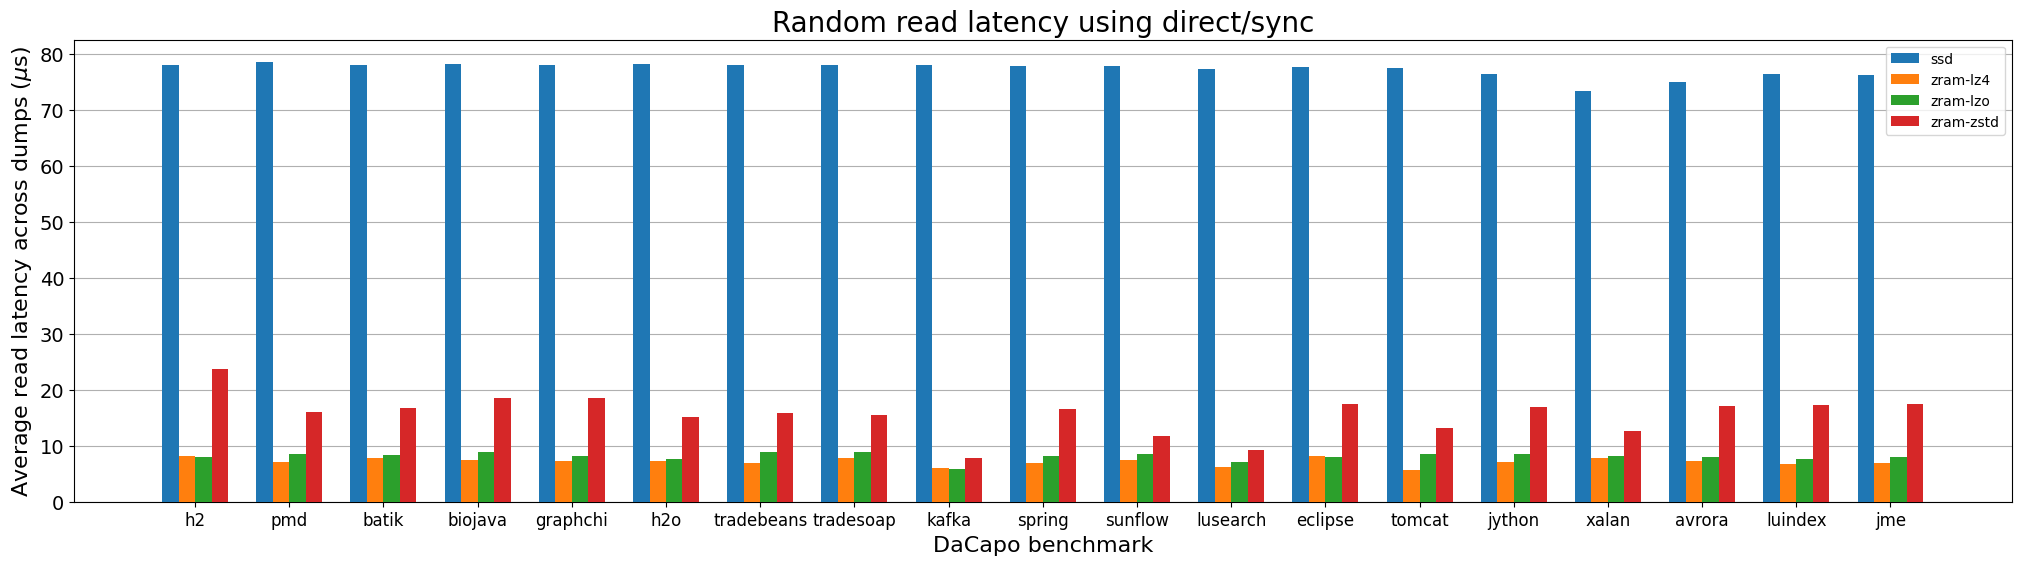

In [96]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.avgreadlat) FROM df_hd_sync AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='randread' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Average read latency across dumps ($\mu$s)",
    title="Random read latency using direct/sync",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/randread-latency-sync.png")

plt.show()

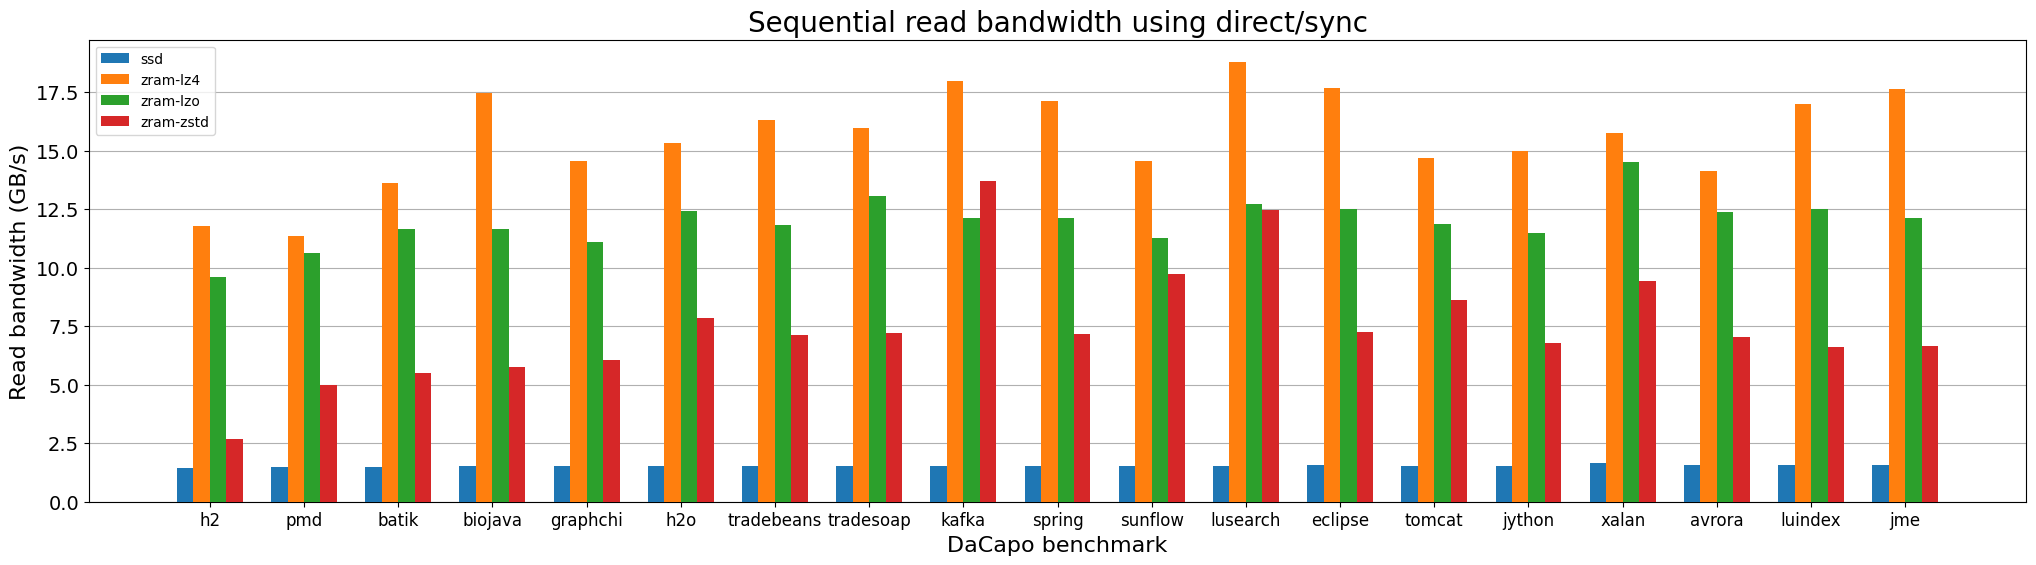

In [104]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.readBW_bytes)/(1024*1024*1024) FROM df_hd_sync AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Read bandwidth (GB/s)",
    title="Sequential read bandwidth using direct/sync",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/seqread-bw-sync.png")

plt.show()

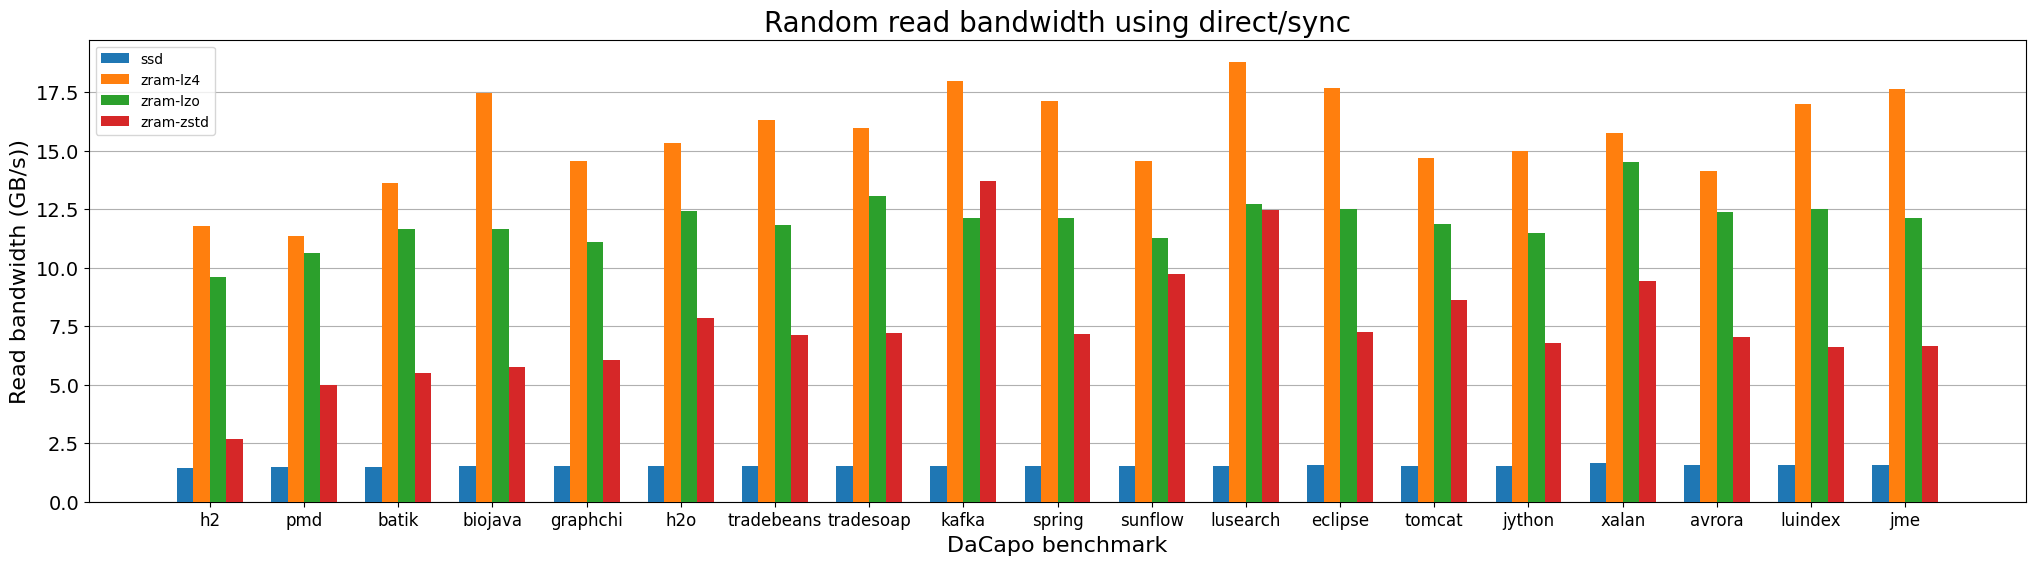

In [20]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.readBW_bytes)/(1024*1024*1024) FROM df_hd_sync AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd_sync ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Read bandwidth (GB/s))",
    title="Random read bandwidth using direct/sync",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/randread-bw-sync.png")

plt.show()

# SPLIT FILE

In [5]:
df_split_file_1 = pd.read_csv("../../data/2025-07-09-time-12-03-25-fourth-run-dumps-part-1/master.csv")
df_split_file_2 = pd.read_csv("../../data/2025-07-10-time-11-38-51-fourth-run-dumps-part-2/master.csv")
df_split_file_3 = pd.read_csv("../../data/2025-07-09-time-21-17-01-fourth-run-dumps-part-3/master.csv")
df_split_file = sq("SELECT * FROM df_split_file_1 UNION SELECT * FROM df_split_file_2 UNION SELECT * FROM df_split_file_3")
df_split_file.head()

,Unnamed: 0,cbSize,cioengine,ciodepth,crw,cnproc,cdevice,cdirect,cmemlim,cdumpbc,...,diskutil-TOTAL_WRITES(KB),diskutil-TOTAL_READS(MB),diskutil-TOTAL_WRITES(MB),diskutil-TOTAL_READS(GB),diskutil-TOTAL_WRITES(GB),diskutil-rMB/s,diskutil-wMB/s,diskutil-AVGRQ-SZ,diskutil-AVGQU-SZ,diskutil-DEV_UTIL
0,0,4096,mmap,1,randread,1,ssd,1,none,avrora,...,0.0,32768.0,0.0,32.0,0.0,1354.27,0.229167,4.32000,25.8104,94.4479
1,0,4096,mmap,1,randread,1,zram-lzo,1,none,h2,...,516.0,32768.0,0.0,32.0,0.0,6555.79,0.272000,4.01600,8.0140,71.7100
2,0,4096,mmap,1,randread,1,zram-zstd,1,none,avrora,...,0.0,32768.0,0.0,32.0,0.0,3595.23,0.084444,4.00889,16.1356,84.9978
3,1,4096,mmap,1,randread,1,ssd,1,none,avrora,...,0.0,32768.0,0.0,32.0,0.0,1352.47,0.229167,4.32000,25.7642,94.3908
4,1,4096,mmap,1,randread,1,zram-lzo,1,none,h2,...,500.0,32768.0,0.0,32.0,0.0,6338.51,0.270000,4.01600,9.3000,71.9500


In [6]:
df_split_file.columns

Index(['Unnamed: 0', 'cbSize', 'cioengine', 'ciodepth', 'crw', 'cnproc',
       'cdevice', 'cdirect', 'cmemlim', 'cdumpbc', 'cdumpno', 'cfile',
       'readBW_bytes', 'readBW', 'writeBW_bytes', 'writeBW', 'avgreadlat_ns',
       'avgreadlat', 'avgwritelat_ns', 'avgwritelat', 'USR_UTIL_perc',
       'SYS_UTIL_perc', 'IOW_UTIL_perc', 'IDL_UTIL_perc', 'CPU_UTIL_perc',
       'diskutil-TOTAL_READS(KB)', 'diskutil-TOTAL_WRITES(KB)',
       'diskutil-TOTAL_READS(MB)', 'diskutil-TOTAL_WRITES(MB)',
       'diskutil-TOTAL_READS(GB)', 'diskutil-TOTAL_WRITES(GB)',
       'diskutil-rMB/s', 'diskutil-wMB/s', 'diskutil-AVGRQ-SZ',
       'diskutil-AVGQU-SZ', 'diskutil-DEV_UTIL'],
      dtype='object')

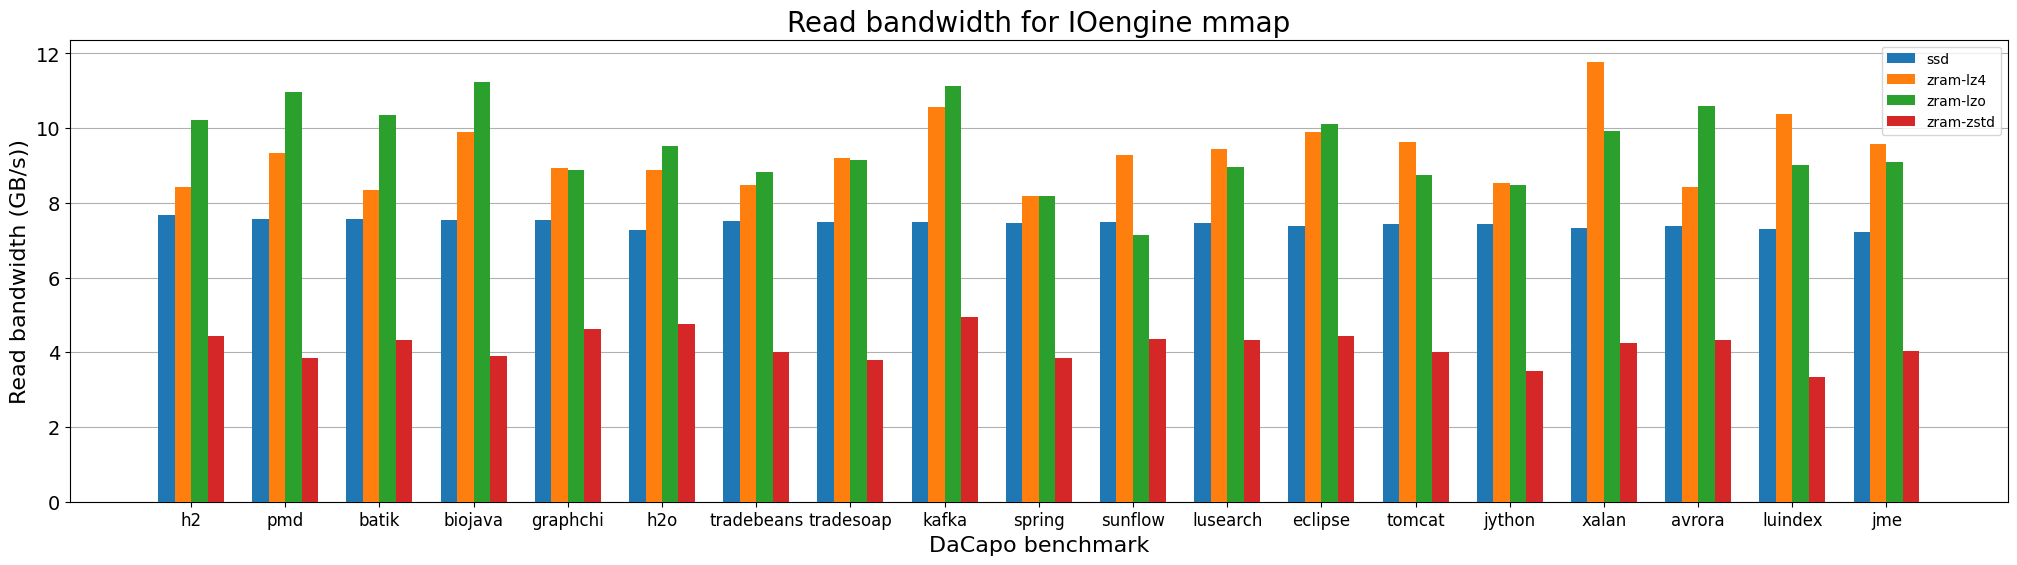

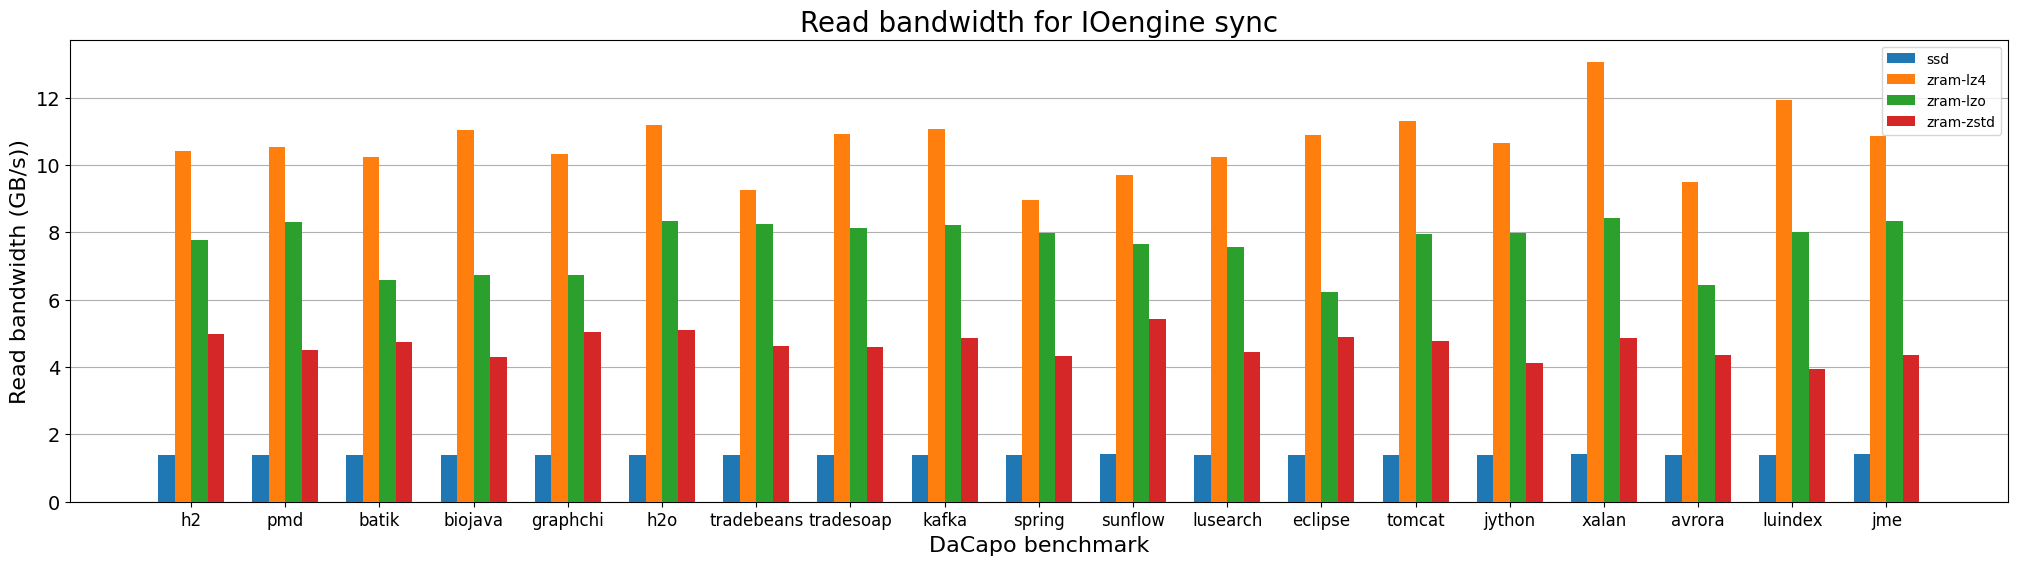

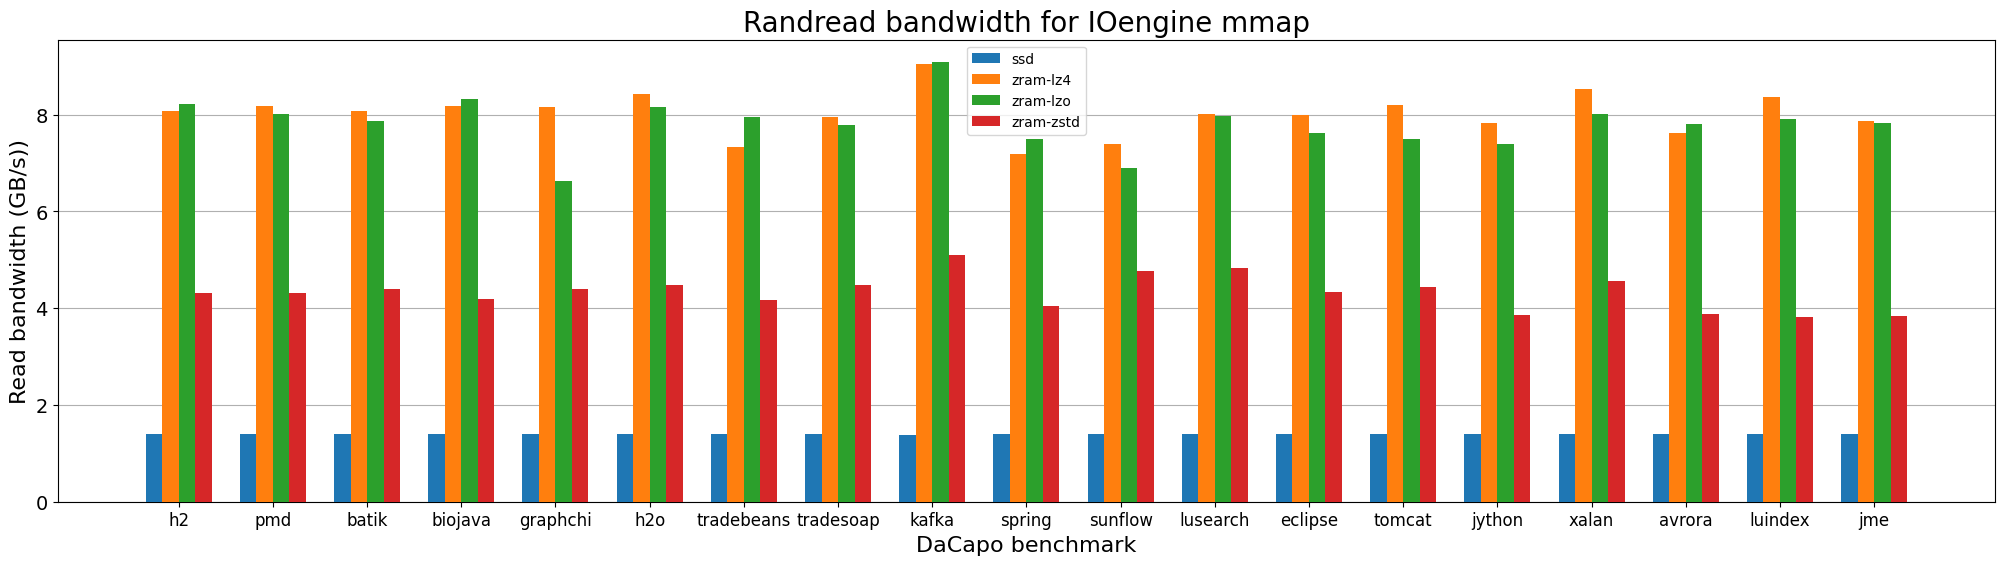

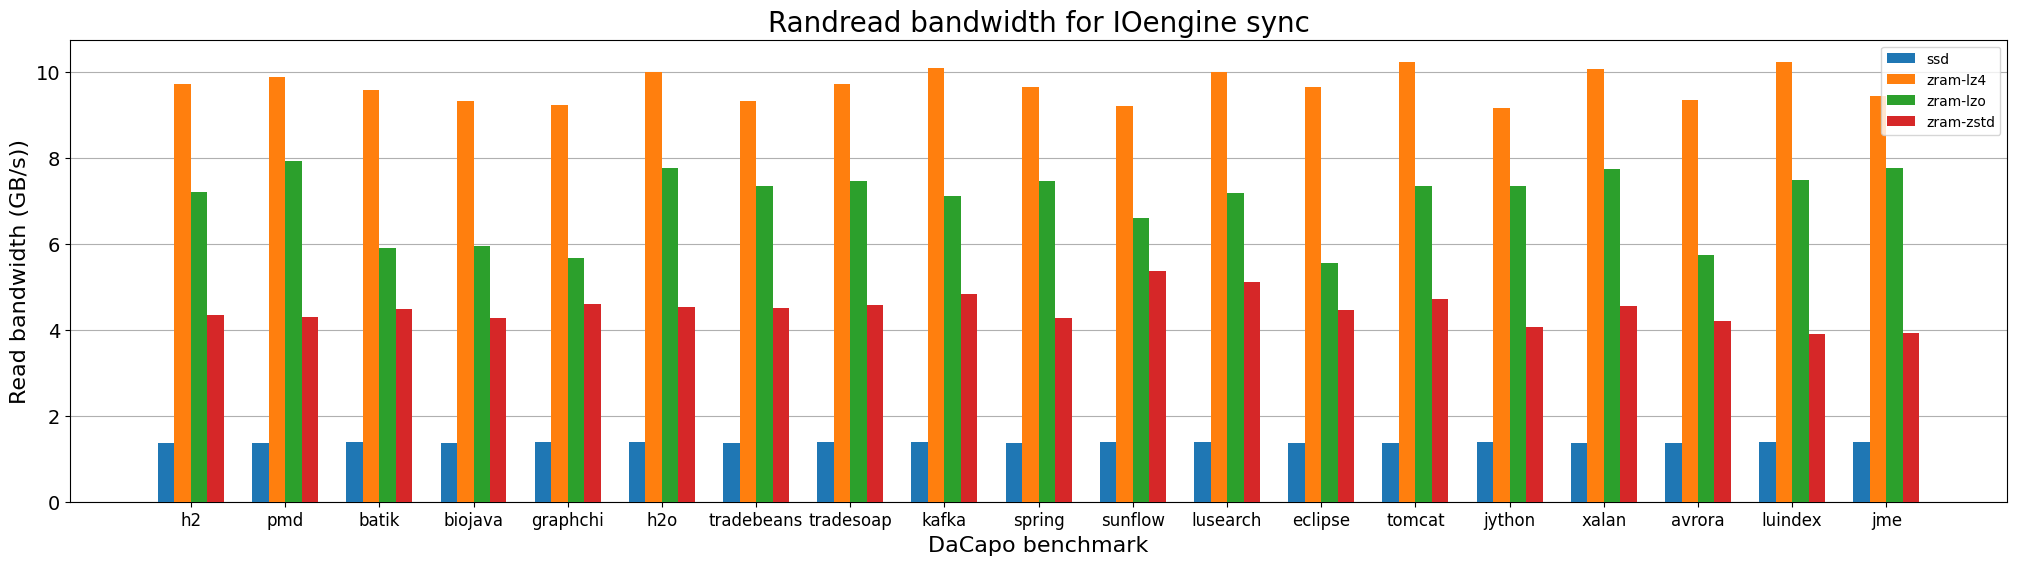

In [8]:
for crw in ["read", "randread"]:
    for cioengine in ["mmap", "sync"]:
        alib.grouped_barplot_flat(
            sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
            sqflat(f"SELECT AVG(d.readBW_bytes)/(1024*1024*1024) FROM df_split_file AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='{crw}' AND d.cioengine='{cioengine}' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
            labels=sqflat("SELECT DISTINCT cdevice FROM df_split_file ORDER BY cdevice"),
            figsize=[25, 6],
            xlabel="DaCapo benchmark",
            ylabel="Read bandwidth (GB/s))",
            title=f"{crw.capitalize()} bandwidth for IOengine {cioengine}",
            show=False
        )

        plt.gca().get_yaxis().label.set_fontsize(16)
        plt.gca().get_xaxis().label.set_fontsize(16)
        plt.gca().title.set_fontsize(20)
        plt.gca().tick_params(axis='x', labelsize=12)
        plt.gca().tick_params(axis='y', labelsize=14)

        plt.savefig(f"../../processed-data/2025-07-10-heapdump-3/{crw}-{cioengine}-readBW", bbox_inches='tight')

        plt.show()

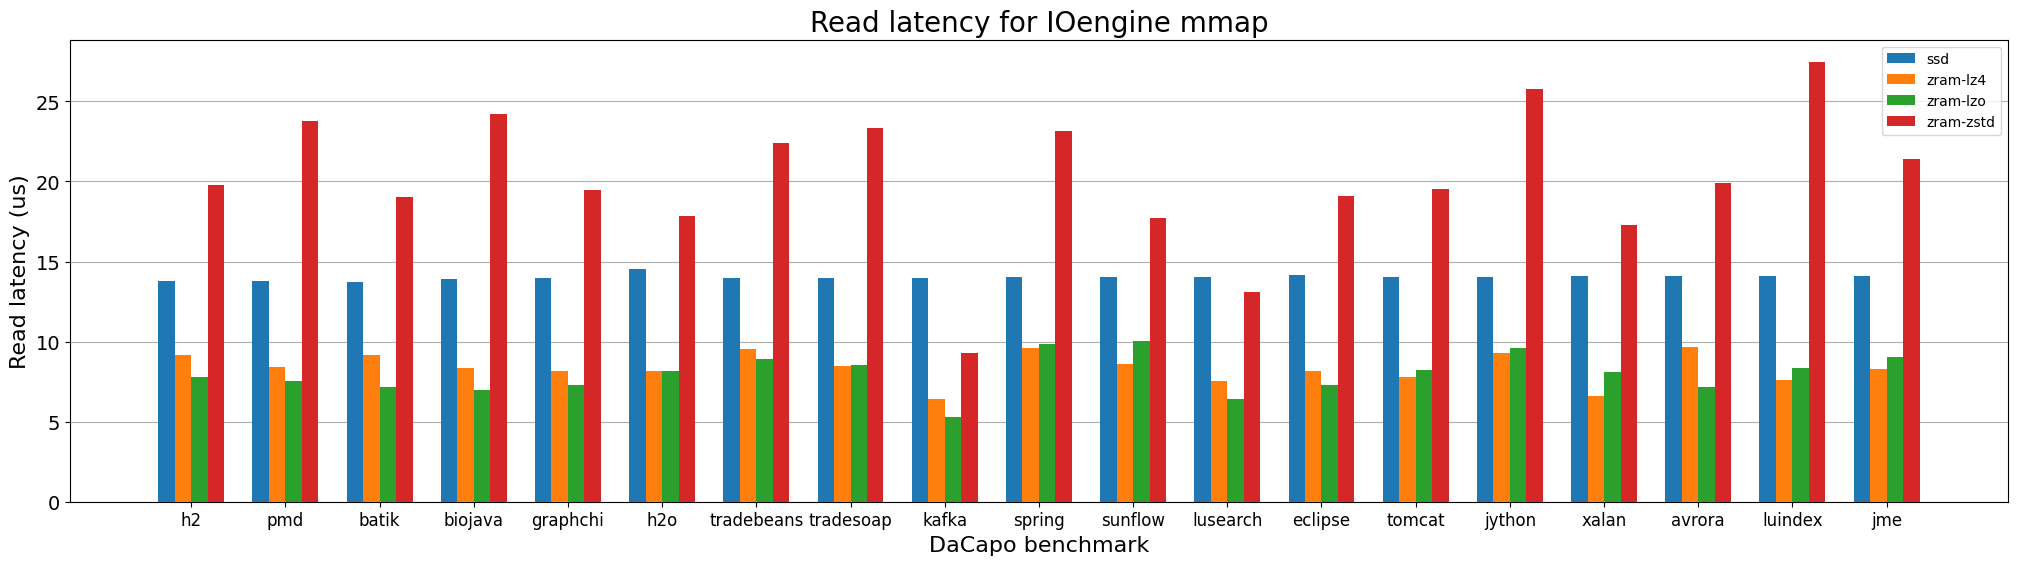

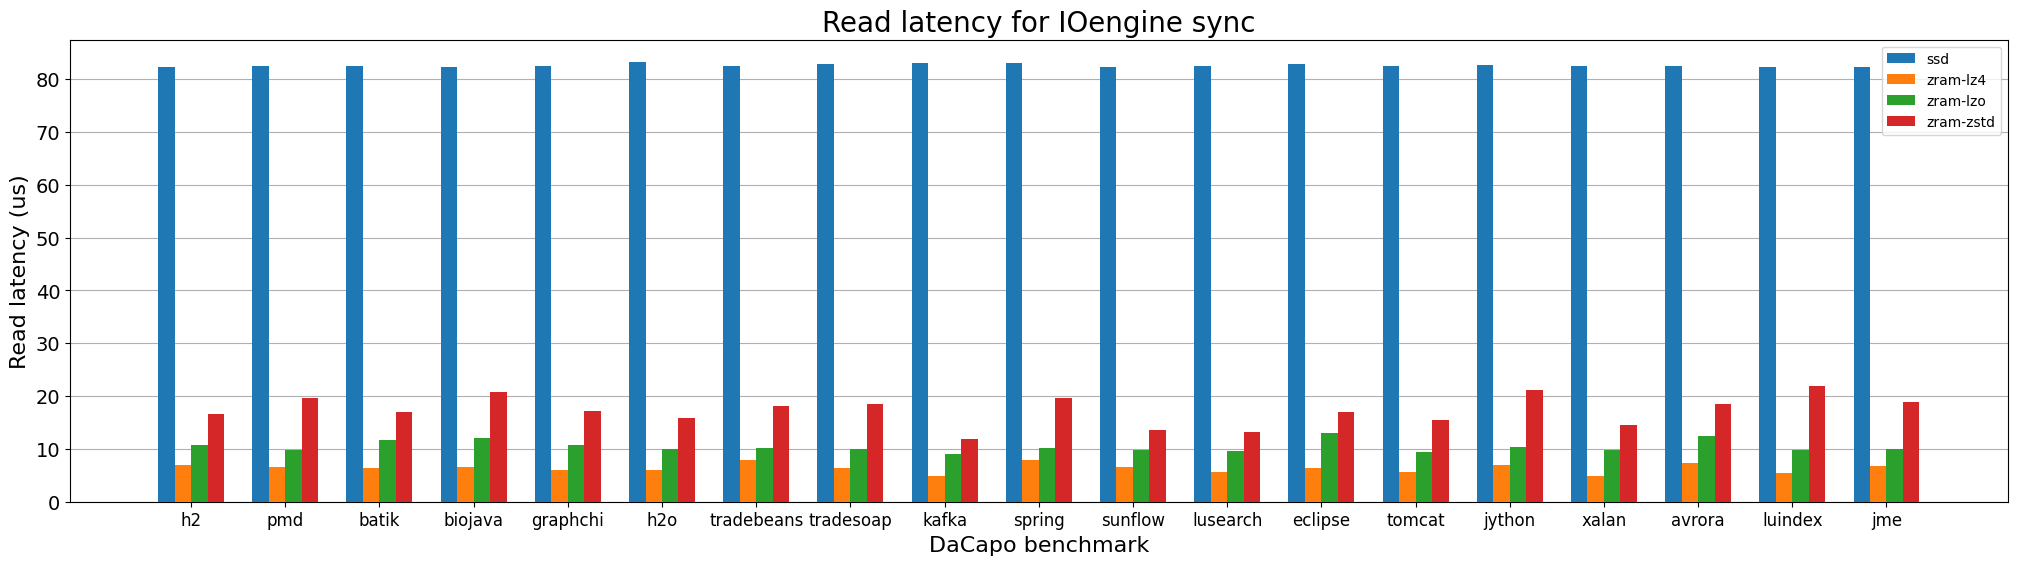

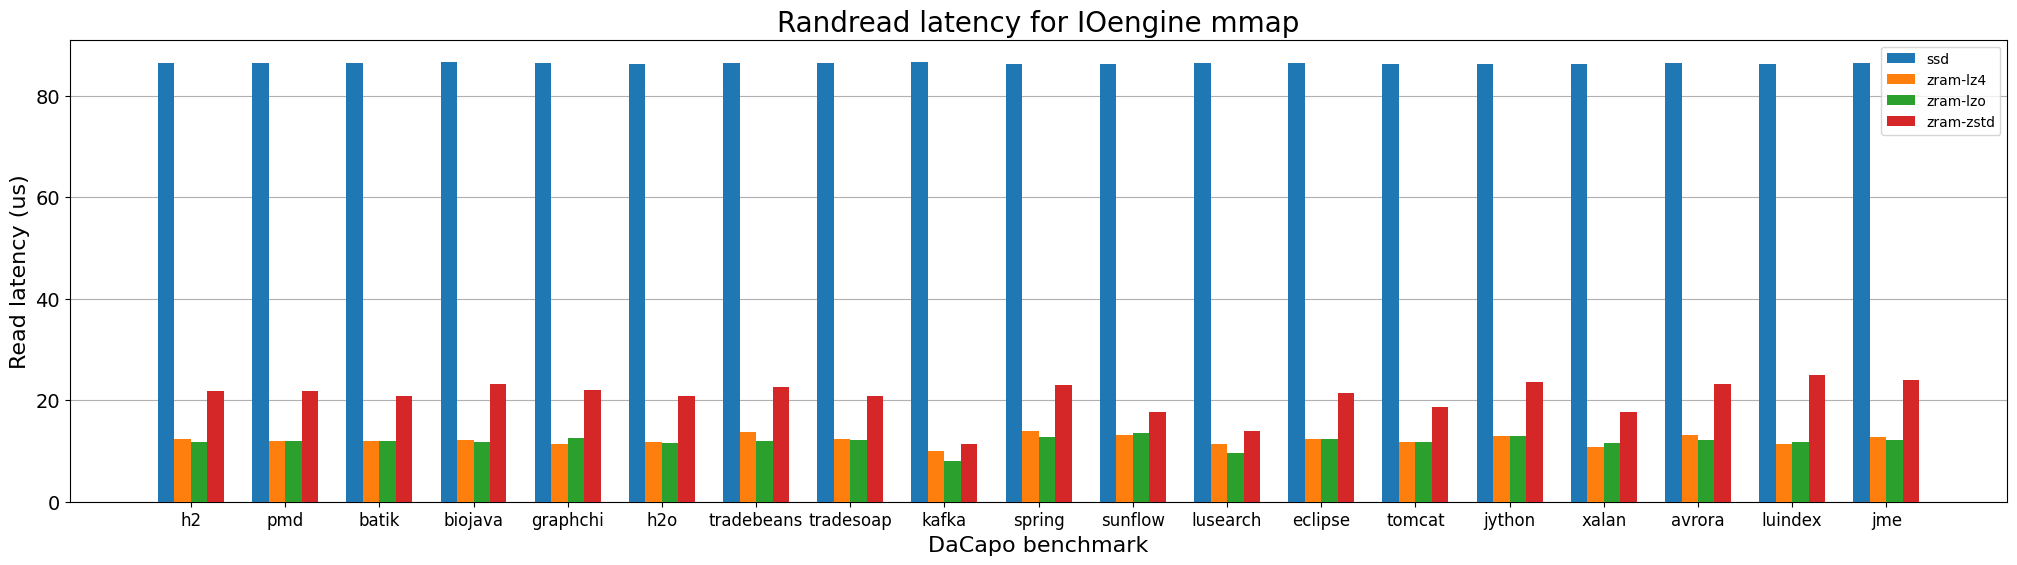

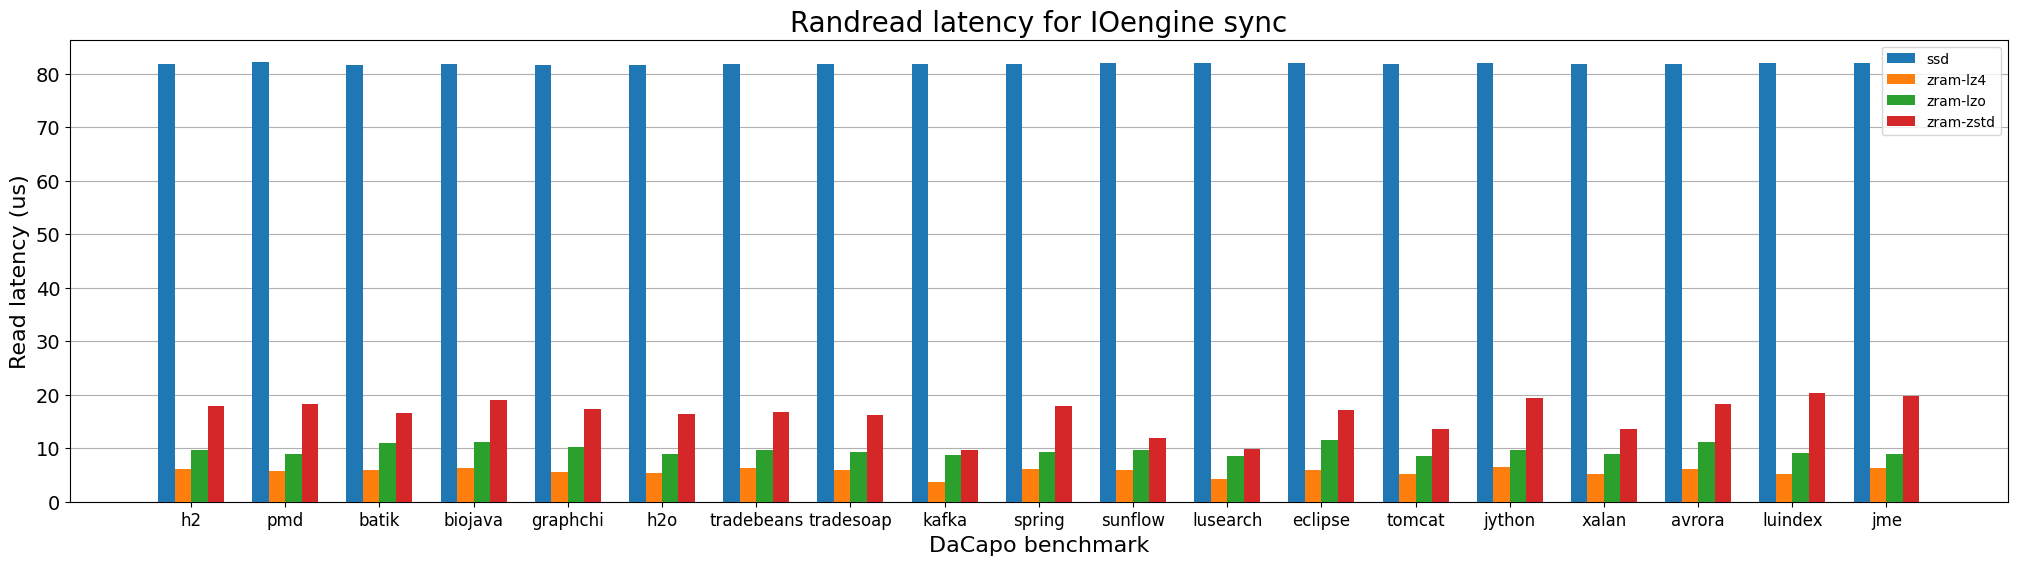

In [9]:
for crw in ["read", "randread"]:
    for cioengine in ["mmap", "sync"]:
        alib.grouped_barplot_flat(
            sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
            sqflat(f"SELECT AVG(d.avgreadlat_ns)/(1000) FROM df_split_file AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='{crw}' AND d.cioengine='{cioengine}' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
            labels=sqflat("SELECT DISTINCT cdevice FROM df_split_file ORDER BY cdevice"),
            figsize=[25, 6],
            xlabel="DaCapo benchmark",
            ylabel="Read latency (us)",
            title=f"{crw.capitalize()} latency for IOengine {cioengine}",
            show=False
        )

        plt.gca().get_yaxis().label.set_fontsize(16)
        plt.gca().get_xaxis().label.set_fontsize(16)
        plt.gca().title.set_fontsize(20)
        plt.gca().tick_params(axis='x', labelsize=12)
        plt.gca().tick_params(axis='y', labelsize=14)

        plt.savefig(f"../../processed-data/2025-07-10-heapdump-3/{crw}-{cioengine}-readlat", bbox_inches='tight')

        plt.show()